# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 26.04.2021

Мягкий дедлайн: 10.05.2021 00:59 MSK

Жёсткий дедлайн: 14.05.2021 00:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [3]:
# Оформление 
from typing import List, Tuple, Dict, Union, Optional

# Картинки
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"glebkhaykin","key":"7c9ad7ce3add55895cad57b709dcaaff"}'}

In [6]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip


Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


100%|##########| 66.0M/66.0M [00:00<00:00, 75.0MB/s]


In [7]:
df = pd.read_csv('creditcard.csv')

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 — это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [7]:
sum(df['Class'] == 1) / (sum(df['Class'] == 0) + sum(df['Class'] == 1))

0.001727485630620034

Как видим, доля положительных объектов составляет около $0.2\%$.

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [9]:
import time

In [10]:
df['Hour'] = df['Time'].apply(lambda seconds: time.gmtime(seconds).tm_hour)
df['Day'] = df['Time'].apply(lambda seconds: time.gmtime(seconds).tm_mday - 1)

In [10]:
max(df['Day'])

1

Данные покрывают всего лишь два дня.

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

#### Распределение числа транзакций по каждому часу

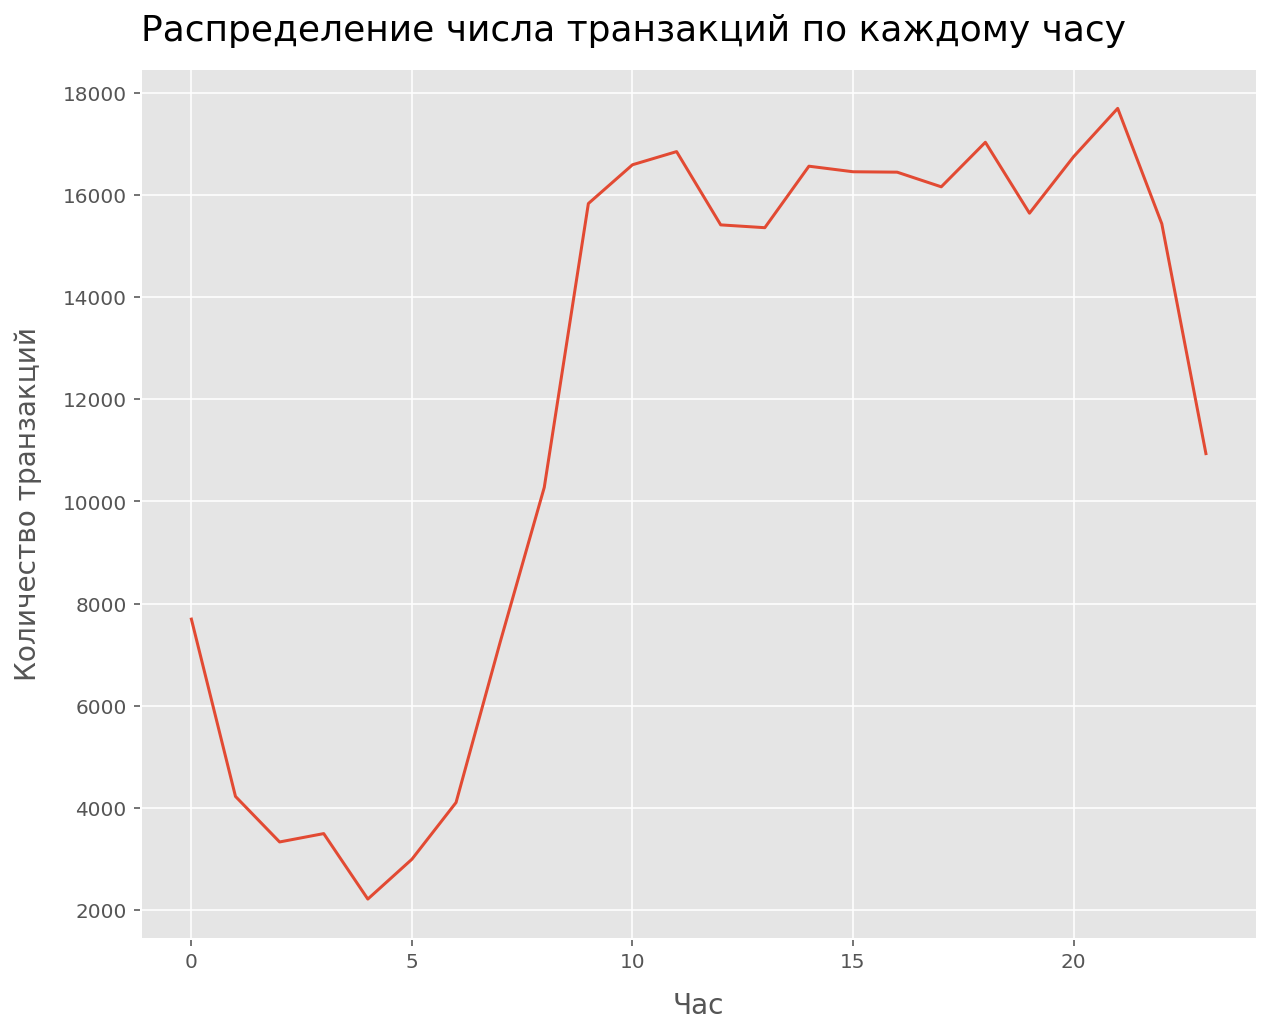

In [66]:
dist_by_hour = df.groupby('Hour').size().to_numpy()
hours = np.arange(24)

plt.title('Распределение числа транзакций по каждому часу', pad=14, fontsize=18, loc='left')
plt.xlabel('Час', labelpad=10, fontsize=14)
plt.ylabel('Количество транзакций', labelpad=10, fontsize=14)

plt.plot(hours, dist_by_hour);

#### Распределение доли мошеннических транзакций по каждому часу

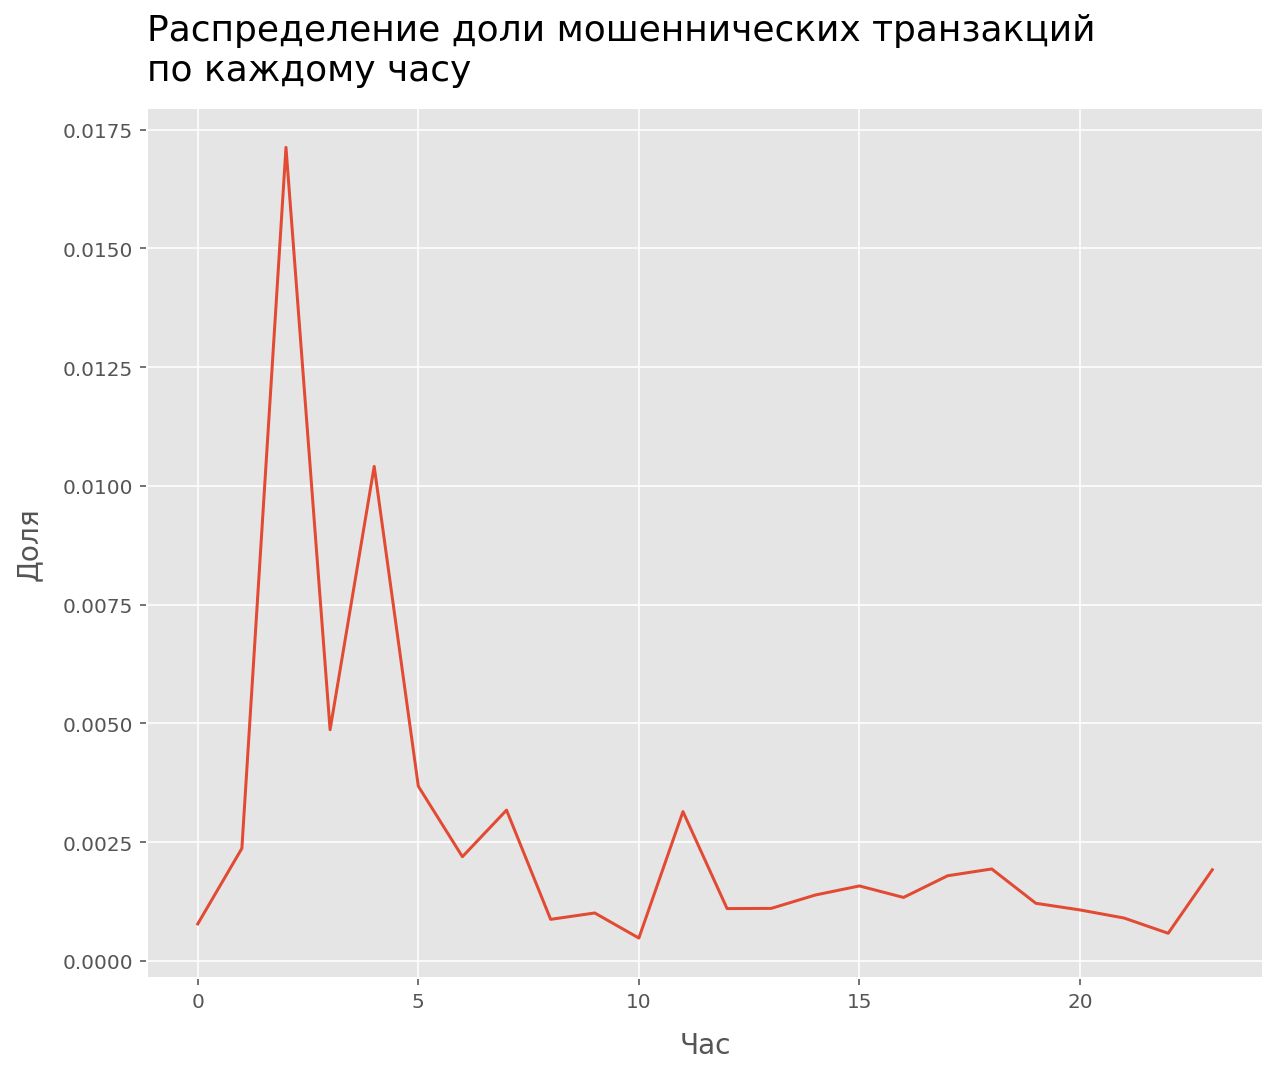

In [ ]:
fraud_dist_by_hour = df[df['Class'] == 1].groupby('Hour').size().to_numpy()
percentage_dist_by_hour = fraud_dist_by_hour / dist_by_hour
hours = np.arange(24)

plt.title('Распределение доли мошеннических транзакций \nпо каждому часу', pad=14, fontsize=18, loc='left')
plt.xlabel('Час', labelpad=10, fontsize=14)
plt.ylabel('Доля', labelpad=10, fontsize=14)

plt.plot(hours, percentage_dist_by_hour);

#### Распределение числа транзакций по каждому дню

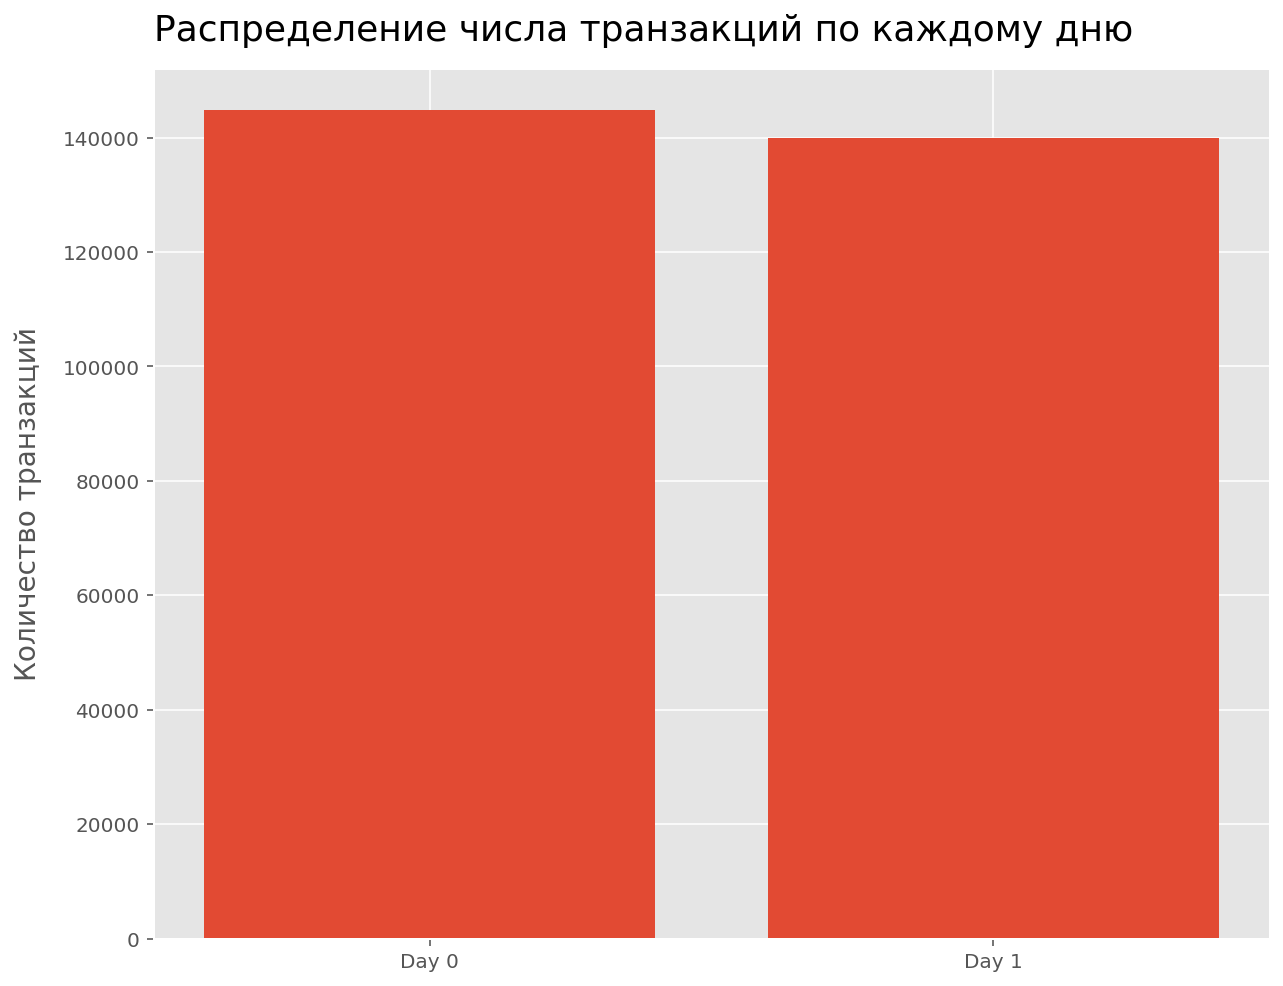

In [ ]:
dist_by_day = df.groupby('Day').size().to_numpy()
days = ['Day 0', 'Day 1']

plt.title('Распределение числа транзакций по каждому дню', pad=14, fontsize=18, loc='left')
plt.ylabel('Количество транзакций', labelpad=10, fontsize=14)

plt.bar(days, dist_by_day);

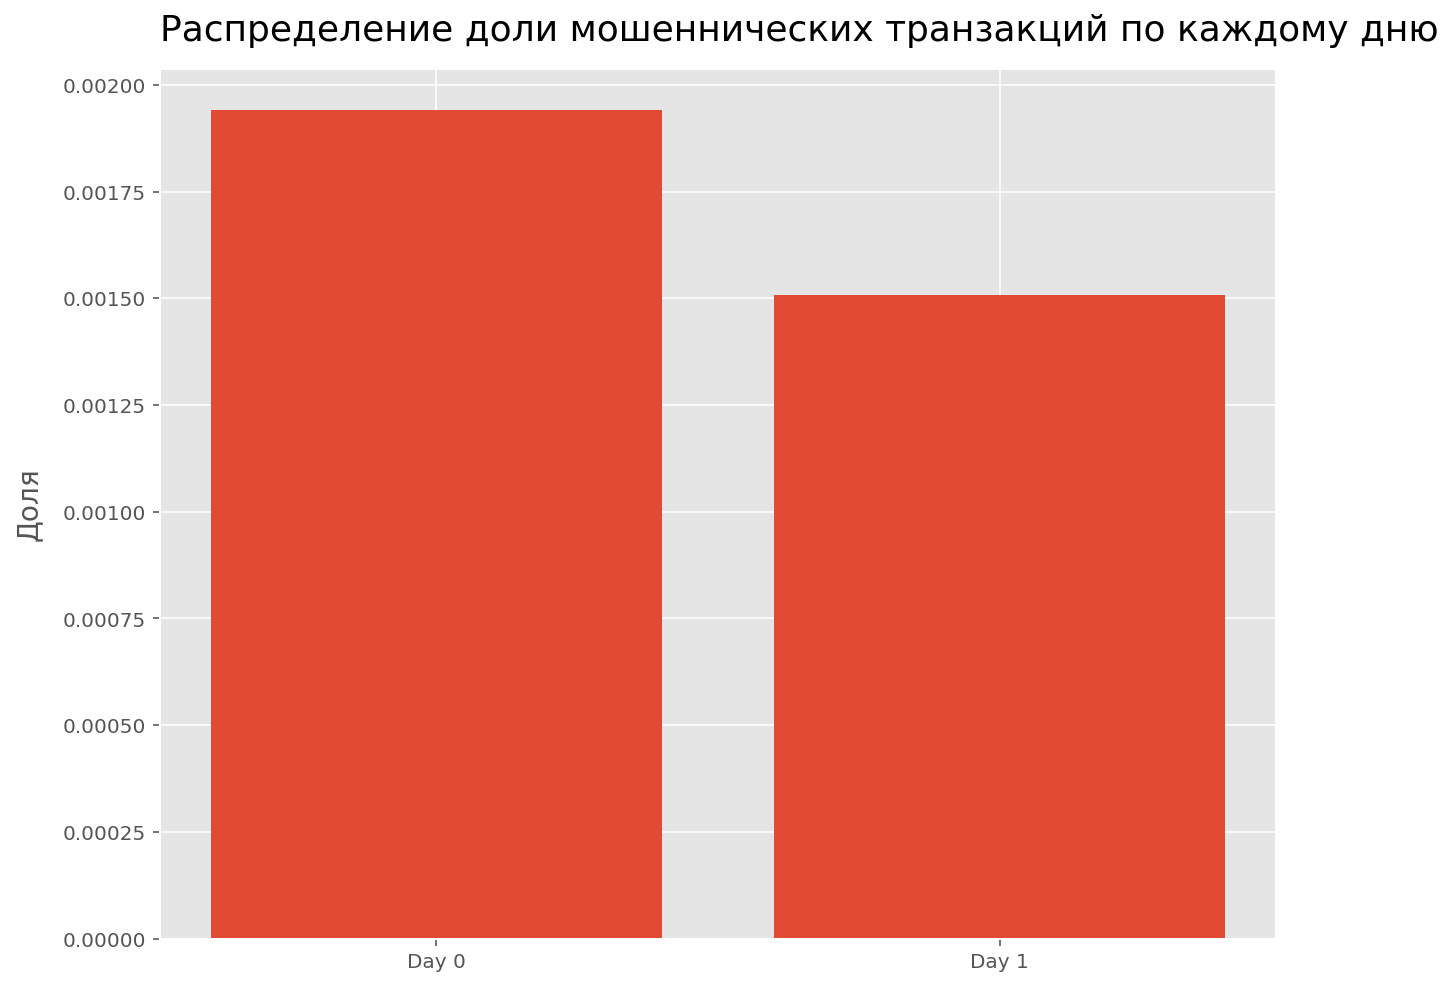

In [ ]:
fraud_dist_by_day = df[df['Class'] == 1].groupby('Day').size().to_numpy()
percentage_dist_by_day = fraud_dist_by_day / dist_by_day
days = ['Day 0', 'Day 1']

plt.title('Распределение доли мошеннических транзакций по каждому дню', pad=14, fontsize=18, loc='left')
plt.ylabel('Доля', labelpad=10, fontsize=14)

plt.bar(days, percentage_dist_by_day);

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

__Вывод__: мошеннические транзакции происходят в основном либо ночью, либо днем. В принципе, можно связать наши полученные часы с реальными часами в сутках, поскольку легче проводить мошеннические транзакции ночью (шансов блокировки карты намного меньше).

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [67]:
corrs = abs(df.drop(labels=['Class', 'Time', 'Amount', 'Hour', 'Day'],  axis=1).corrwith(df['Class']).to_numpy())
variables = list(range(1, len(corrs) + 1))

In [68]:
variables_sorted = sorted(variables, key = lambda v: corrs[v - 1], reverse=True)
variables_sorted

[17,
 14,
 12,
 10,
 16,
 3,
 7,
 11,
 4,
 18,
 1,
 9,
 5,
 2,
 6,
 21,
 19,
 20,
 8,
 27,
 28,
 24,
 13,
 26,
 15,
 25,
 23,
 22]

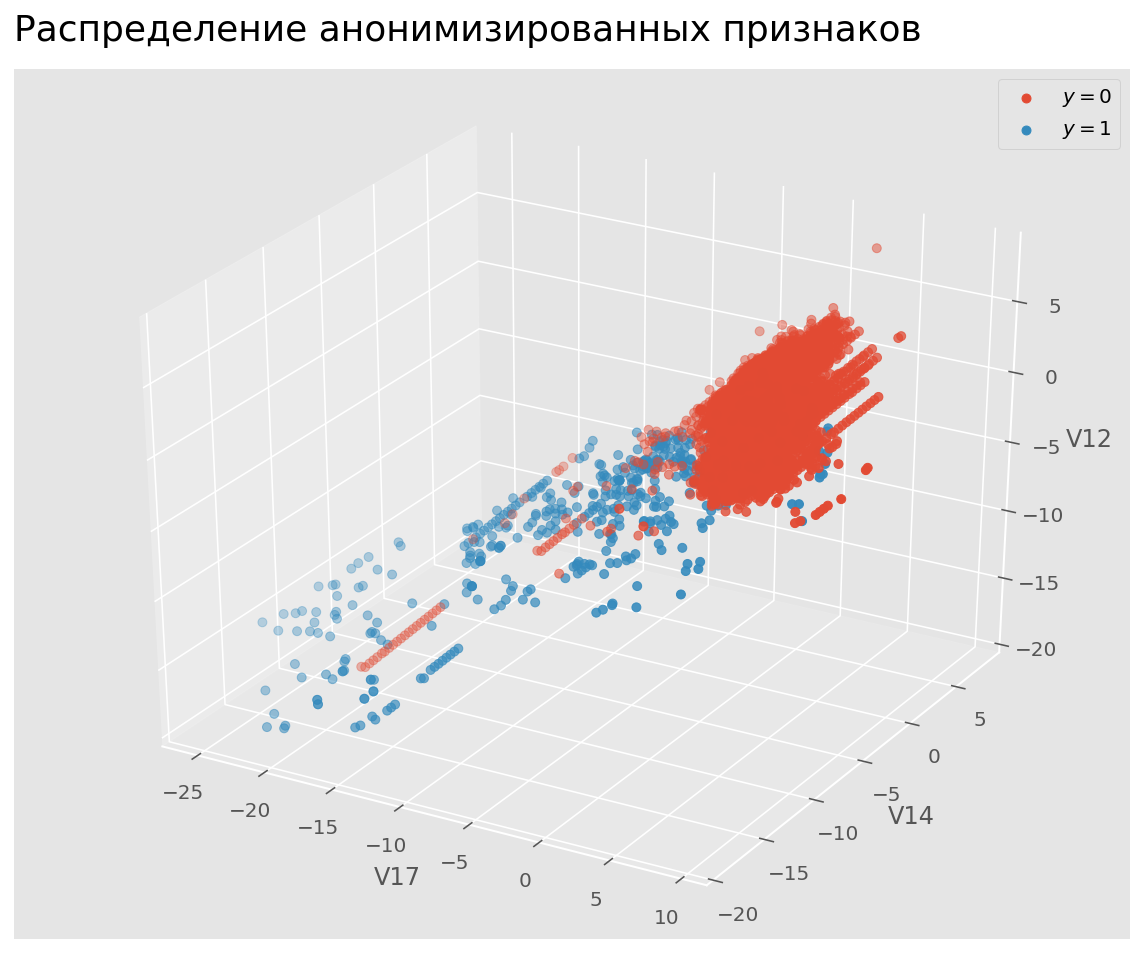

In [ ]:
ax = plt.axes(projection='3d')

ax.scatter3D(df['V17'][df['Class'] == 0], df['V12'][df['Class'] == 0], 
             df['V12'][df['Class'] == 0], label='$y = 0$')

ax.scatter3D(df['V17'][df['Class'] == 1], df['V12'][df['Class'] == 1], 
             df['V12'][df['Class'] == 1], label='$y = 1$')

ax.set_xlabel('V17')
ax.set_ylabel('V14')
ax.set_zlabel('V12')

ax.set_title('Распределение анонимизированных признаков', pad=14, fontsize=18, loc='left')

ax.legend();

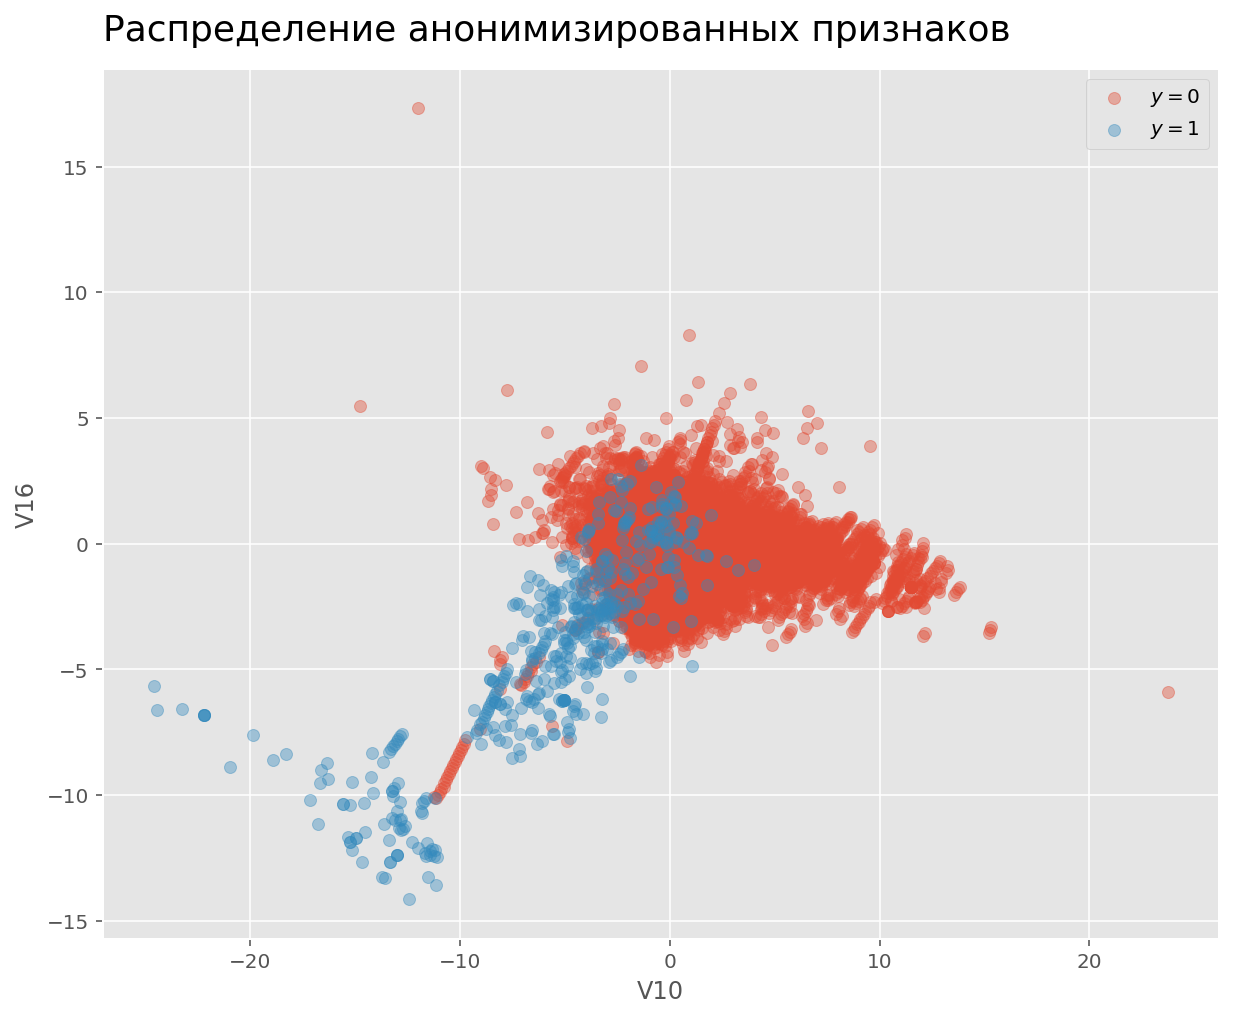

In [ ]:
plt.scatter(df['V10'][df['Class'] == 0], df['V16'][df['Class'] == 0], 
            label='$y = 0$', alpha=0.4)

plt.scatter(df['V10'][df['Class'] == 1], df['V16'][df['Class'] == 1], 
            label='$y = 1$', alpha=0.4)

plt.legend(loc='best')

plt.title('Распределение анонимизированных признаков', pad=14, fontsize=18, loc='left')

plt.xlabel('V10')
plt.ylabel('V16');

По отдельности:

In [ ]:
columns = ['V' + str(variable) for variable in variables_sorted]

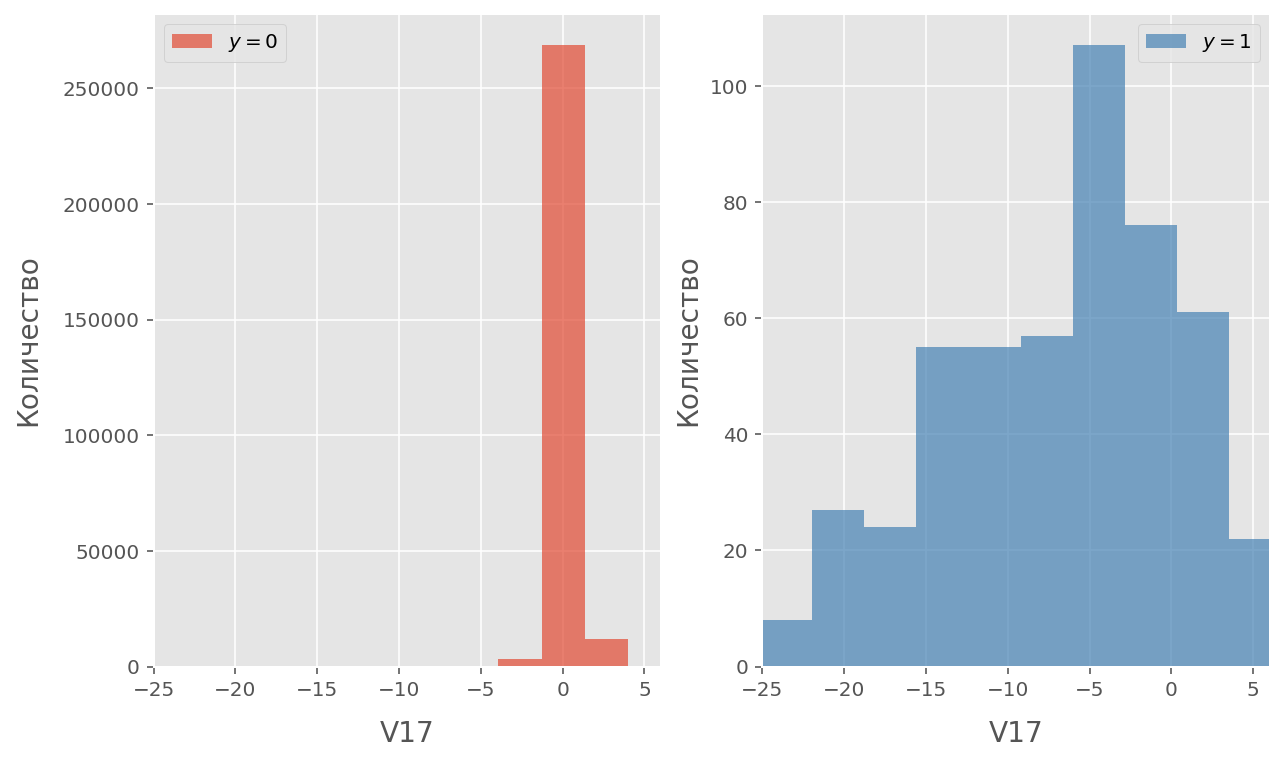

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 6))

ax_1.set_ylabel('Количество', fontsize=14, labelpad=10)
ax_1.set_xlabel(f'{columns[0]}', fontsize=14, labelpad=10)
ax_1.hist(df[columns[i+j]][df['Class'] == 0], label="$y = 0$", alpha=0.7)
ax_1.set_xlim(-25, 6)
ax_1.legend()


ax_2.set_ylabel('Количество', fontsize=14)
ax_2.set_xlabel(f'{columns[0]}', fontsize=14, labelpad=10)
ax_2.hist(df[columns[i+j]][df['Class'] == 1], color='steelblue', label="$y = 1$", alpha=0.7)
ax_2.set_xlim(-25, 6)
ax_2.legend();

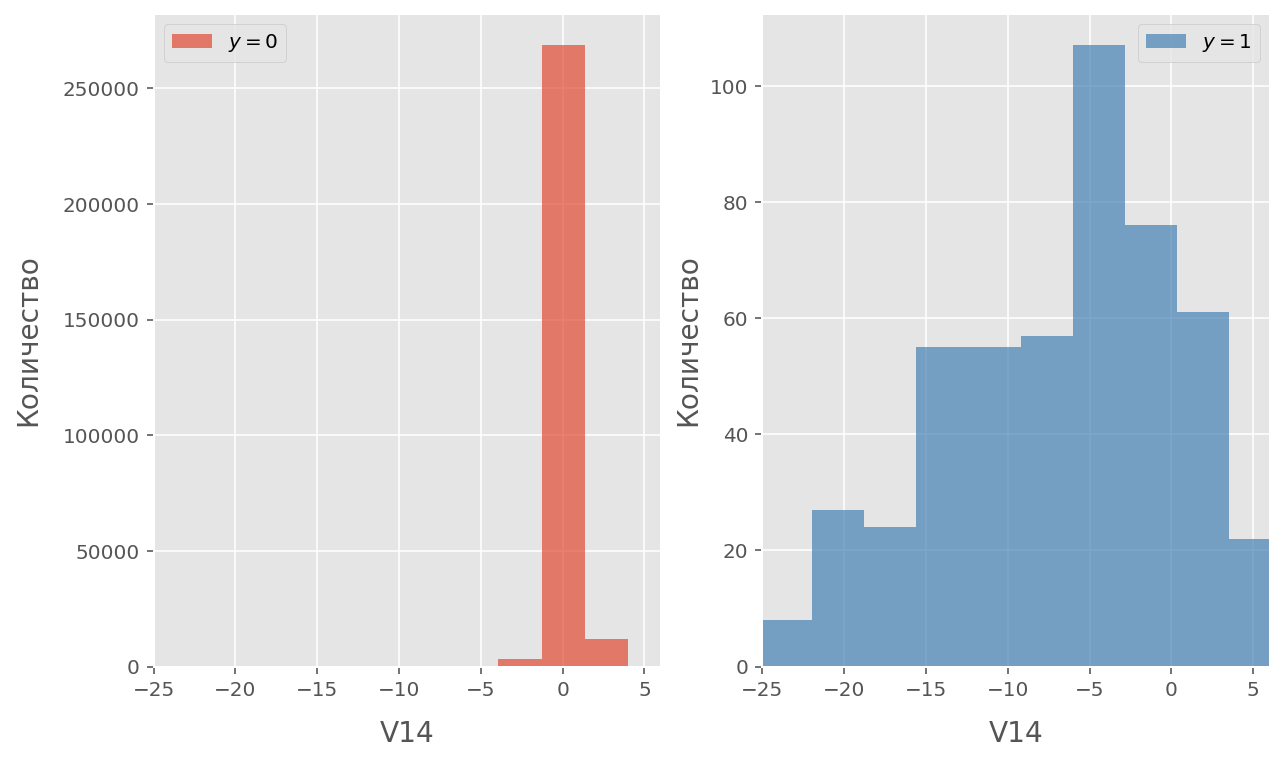

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 6))

ax_1.set_ylabel('Количество', fontsize=14, labelpad=10)
ax_1.set_xlabel(f'{columns[1]}', fontsize=14, labelpad=10)
ax_1.hist(df[columns[i+j]][df['Class'] == 0], label="$y = 0$", alpha=0.7)
ax_1.set_xlim(-25, 6)
ax_1.legend()


ax_2.set_ylabel('Количество', fontsize=14)
ax_2.set_xlabel(f'{columns[1]}', fontsize=14, labelpad=10)
ax_2.hist(df[columns[i+j]][df['Class'] == 1], color='steelblue', label="$y = 1$", alpha=0.7)
ax_2.set_xlim(-25, 6)
ax_2.legend();

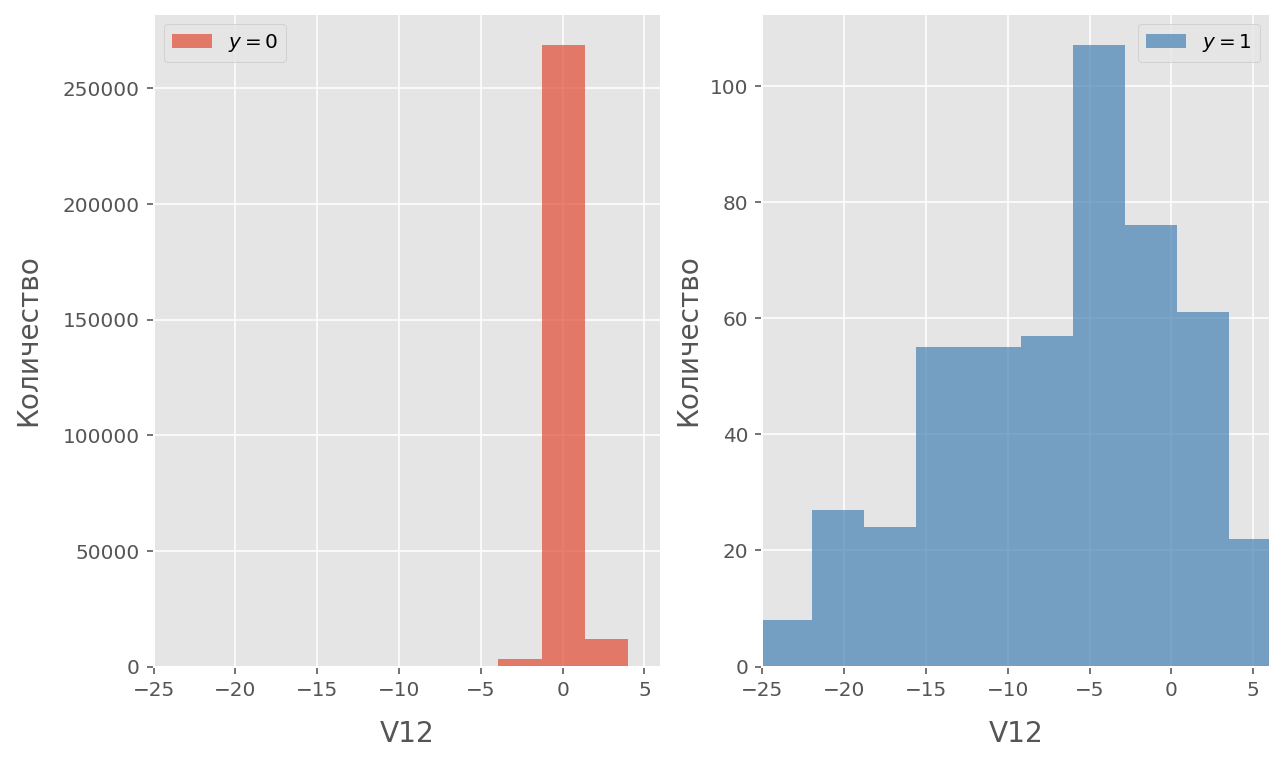

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 6))

ax_1.set_ylabel('Количество', fontsize=14, labelpad=10)
ax_1.set_xlabel(f'{columns[2]}', fontsize=14, labelpad=10)
ax_1.hist(df[columns[i+j]][df['Class'] == 0], label="$y = 0$", alpha=0.7)
ax_1.set_xlim(-25, 6)
ax_1.legend()


ax_2.set_ylabel('Количество', fontsize=14)
ax_2.set_xlabel(f'{columns[2]}', fontsize=14, labelpad=10)
ax_2.hist(df[columns[i+j]][df['Class'] == 1], color='steelblue', label="$y = 1$", alpha=0.7)
ax_2.set_xlim(-25, 6)
ax_2.legend();

__Вывод__: у мошеннических транзакций намного больше дисперсия и совсем иное математическое ожидание.

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени — по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [13]:
X, y = df.drop(['Time', 'Class'], axis=1).to_numpy(), df['Class'].to_numpy()
X_train, y_train = X[:227846], y[:227846]
X_val, y_val = X[227846:256326], y[227846:256326]
X_test, y_test =  X[256326:], y[256326:]

Также отстандартизируем наши данные:

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [14]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [15]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ — доля согласованных предсказаний, а $p_e$ — доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину — вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 — полная согласованность, 0 — согласованность на уровне рандома, -1 — совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [16]:
from sklearn.metrics import cohen_kappa_score

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [17]:
from sklearn.metrics import matthews_corrcoef

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [18]:
def plot_pr_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    plt.title('PR-Curve', pad=14, fontsize=18, loc='left')
    plt.xlabel('Recall', labelpad=10, fontsize=14)
    plt.ylabel('Precision', labelpad=10, fontsize=14)

    plt.plot(recall, precision)

In [19]:
def get_metrics(y_true, y_pred, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    print(f'AUC-PR = {auc(recall, precision):.3}')
    print(f'k = {cohen_kappa_score(y_true, y_pred):.3}')
    print(f'MCC = {matthews_corrcoef(y_true, y_pred):.3}')

In [20]:
y_pred = np.repeat(0, len(y))
y_pred_proba = np.repeat(sum(df['Class'] == 1) / (sum(df['Class'] == 0) + sum(df['Class'] == 1)), len(y))

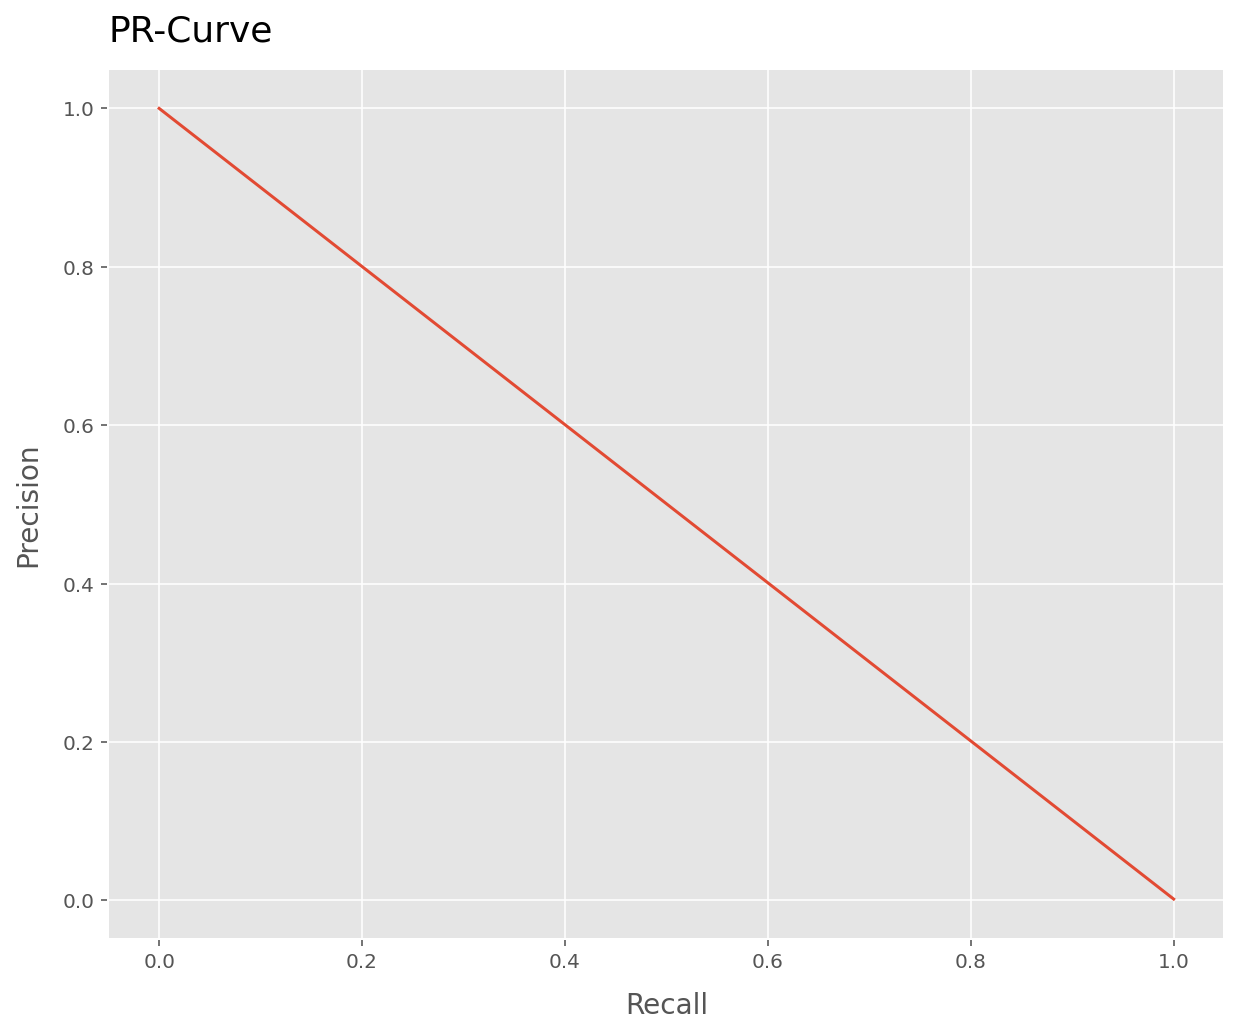

In [21]:
plot_pr_curve(y, y_pred_proba)

In [81]:
get_metrics(y, y_pred, y_pred_proba)

AUC-PR = 0.501
k = 0.0
MCC = 0.0


Все работает: три метрики показали качество рандомного алгоритма.

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [ ]:
!pip install catboost

In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

Проведем отбор гиперпараметров.

In [84]:
param_test_1 = {'depth': np.arange(6, 11, 1)}

grid_search_1 = GridSearchCV(estimator=CatBoostClassifier(iterations=300,
                                                          random_seed=77, logging_level='Silent'), 
                             param_grid=param_test_1, 
                             scoring='average_precision',
                             n_jobs=-1,
                             verbose=1, 
                             cv=5)

grid_search_1.fit(X_val_scaled, y_val)
grid_search_1.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.4min finished


{'depth': 6}

In [85]:
param_test_2 = {'l2_leaf_reg': np.arange(2, 20, 2), 
                'bagging_temperature': np.arange(10, 100, 10)}

grid_search_2 = GridSearchCV(estimator=CatBoostClassifier(depth=grid_search_1.best_params_['depth'], 
                                                          iterations=300,
                                                          random_seed=77, logging_level='Silent'), 
                             param_grid=param_test_2, 
                             scoring='average_precision',
                             n_jobs=-1,
                             verbose=1, 
                             cv=5)

grid_search_2.fit(X_val_scaled, y_val)
grid_search_2.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 54.2min finished


{'bagging_temperature': 10, 'l2_leaf_reg': 2}

In [88]:
param_test_3 = {'learning_rate': np.arange(0.1, 1, 0.1)}

grid_search_3 = GridSearchCV(estimator=CatBoostClassifier(depth=grid_search_1.best_params_['depth'],
                                                          l2_leaf_reg=grid_search_2.best_params_['l2_leaf_reg'],
                                                          bagging_temperature=grid_search_2.best_params_['bagging_temperature'],
                                                          iterations=300,
                                                          random_seed=77, logging_level='Silent'), 
                             param_grid=param_test_3, 
                             scoring='average_precision',
                             n_jobs=-1,
                             verbose=1, 
                             cv=5)

grid_search_3.fit(X_val_scaled, y_val)
grid_search_3.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  45 | elapsed:  5.0min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.2min finished


{'learning_rate': 0.1}

In [89]:
catboost_clf = CatBoostClassifier(depth=grid_search_1.best_params_['depth'],
                                  l2_leaf_reg=grid_search_2.best_params_['l2_leaf_reg'],
                                  bagging_temperature=grid_search_2.best_params_['bagging_temperature'],
                                  learning_rate=grid_search_3.best_params_['learning_rate'],
                                  random_seed=77, 
                                  logging_level='Silent')

catboost_clf.fit(X_train_scaled, y_train);

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

In [90]:
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

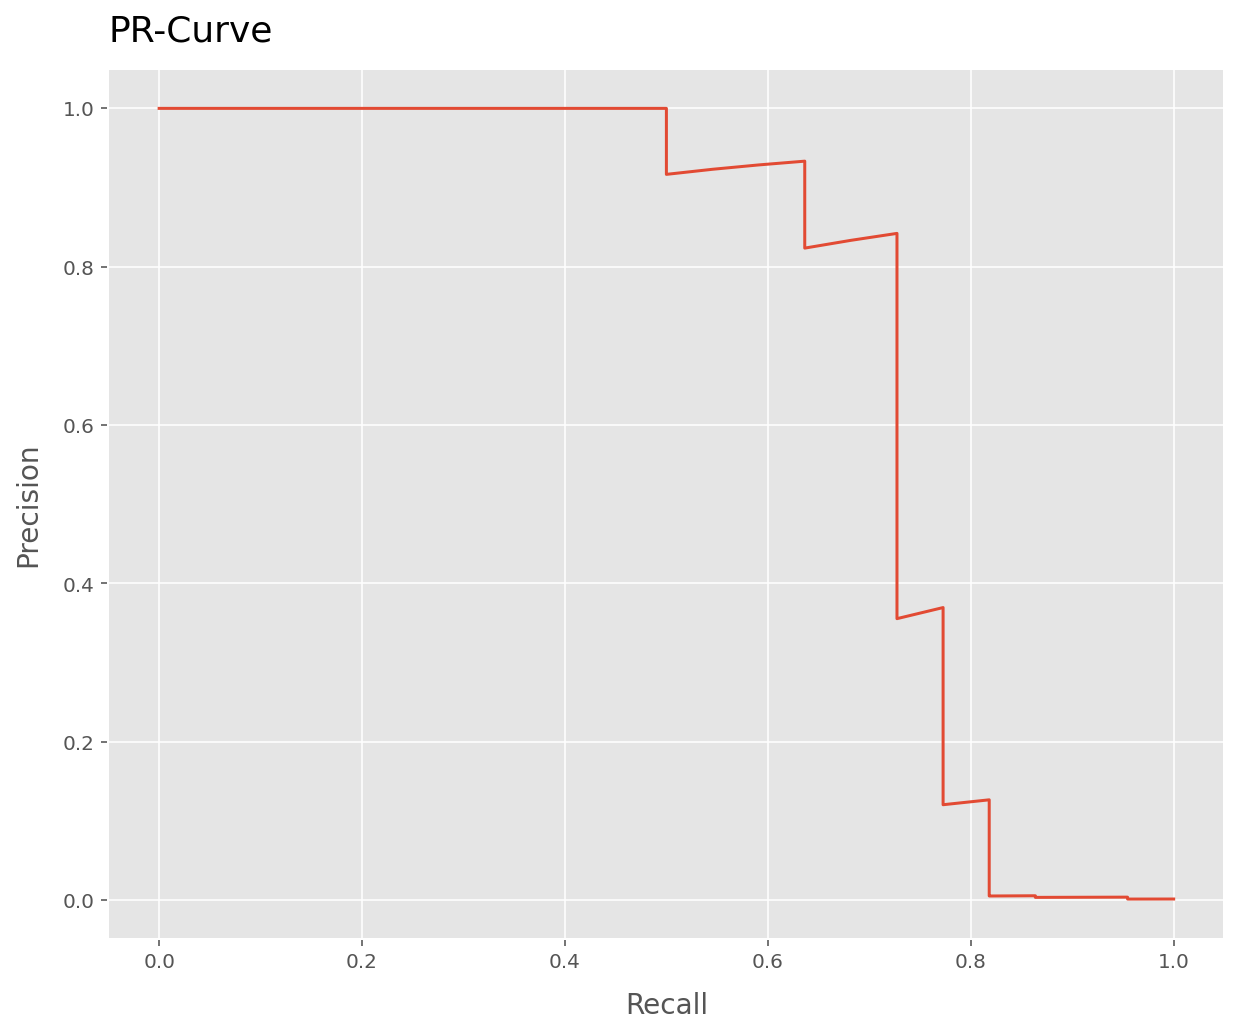

In [91]:
plot_pr_curve(y_test, y_pred_proba)

In [92]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.725
k = 0.718
MCC = 0.724


**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение — просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [93]:
from catboost import Pool

Задаем положительным объектам — объектам из минорного класса — иные веса: 

In [94]:
weight_minor = sum(df['Class'] == 0) / sum(df['Class'] == 1)
weight = np.repeat(1, len(y))
weight[y == 1] = weight_minor

In [95]:
weight_minor

577.8760162601626

In [96]:
weight_train = weight[:227846]

train_data = Pool(data=X_train_scaled,
                  label=y_train,
                  weight=weight_train)

In [97]:
catboost_clf.fit(train_data);

In [98]:
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

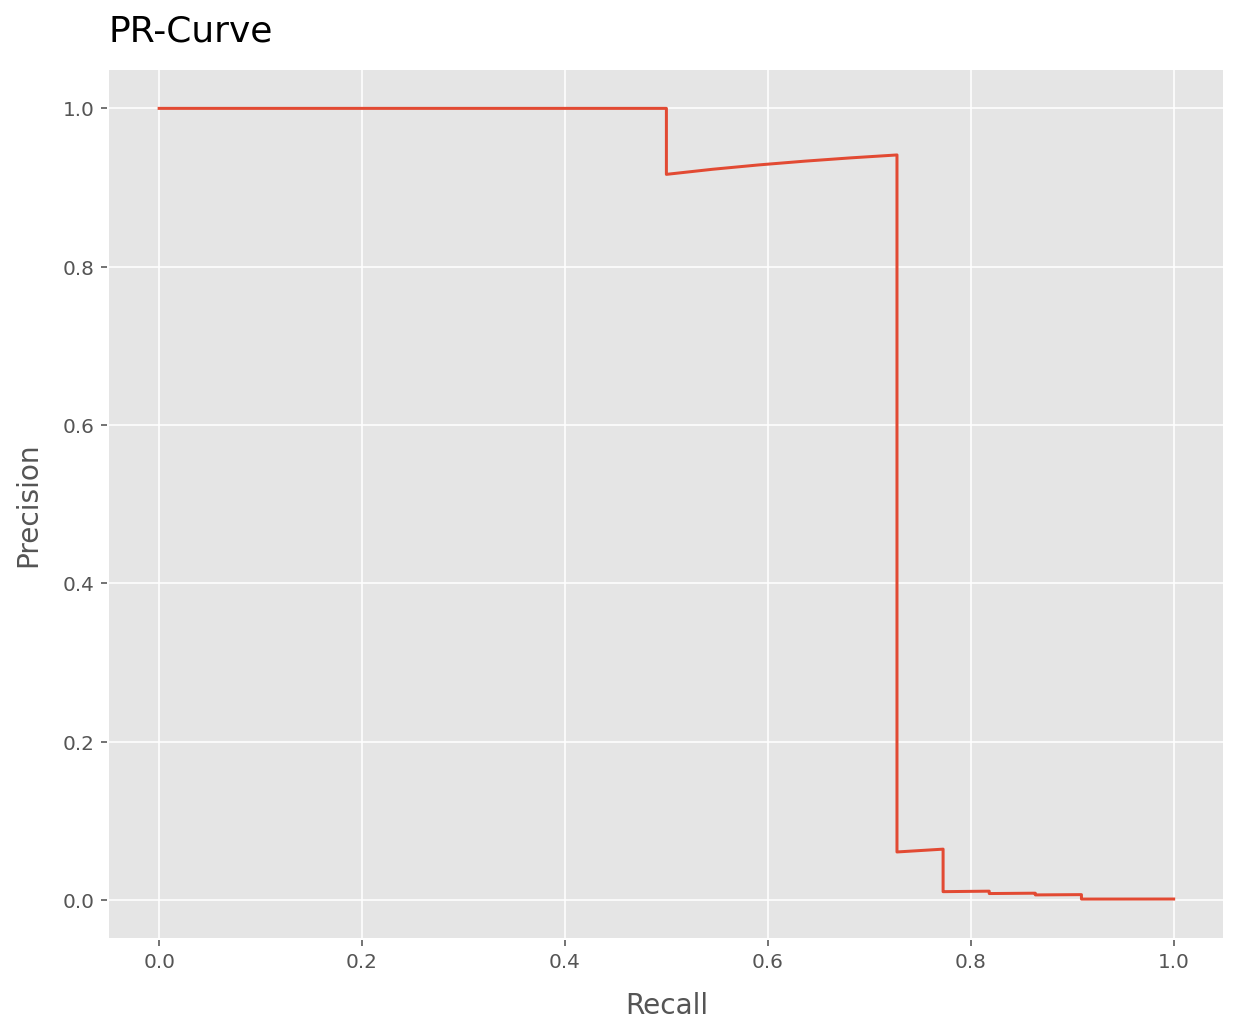

In [99]:
plot_pr_curve(y_test, y_pred_proba)

In [100]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.716
k = 0.711
MCC = 0.711


Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

Сначала подберем веса для минорного класса.

In [101]:
def validate_weight(X_val, y_val, weights_minor, cat_model) -> float:
    scores = []
   
    for weight_minor in tqdm(weights_minor):
        weight_val = np.repeat(1, len(y_val))
        weight_val[y_val == 1] = weight_minor

        val_data = Pool(data=X_val,
                        label=y_val,
                        weight=weight_val)
        
        cat_model.fit(val_data)
        
        y_pred_proba = cat_model.predict_proba(X_val)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
        scores.append(auc(recall, precision))

    return weights_minor[scores.index(max(scores))]

In [102]:
weights_minor = np.hstack((np.arange(0.1, 1, 0.1), np.arange(2, 100, 2), np.arange(100, 5000, 50)))

Определим лучший вес:

In [103]:
best_weight = validate_weight(X_val_scaled, y_val, weights_minor, catboost_clf)
best_weight

2.0

Теперь выберем оптимальный порог бинаризации по МСС при отобранных весах.

In [104]:
def validate_thresholds(X_val, y_val, best_weight, thresholds, cat_model) -> float:
    scores = []

    for threshold in tqdm(thresholds):
        weight_val = np.repeat(1, len(y_val))
        weight_val[y_val == 1] = best_weight

        val_data = Pool(data=X_val,
                        label=y_val,
                        weight=weight_val)
        
        cat_model.fit(val_data)

        y_pred = (cat_model.predict_proba(X_val)[:, 1] > threshold) * 1
        scores.append(matthews_corrcoef(y_val, y_pred))
    
    return thresholds[scores.index(max(scores))]

In [105]:
thresholds = np.arange(0.1, 1, 0.05)
best_threshold = validate_thresholds(X_val_scaled, y_val, best_weight, thresholds, catboost_clf) 

Посчитаем качество.

In [106]:
weight = np.repeat(1, len(y))
weight[y == 1] = best_weight

weight_train = weight[:227846]

train_data = Pool(data=X_train_scaled,
                  label=y_train,
                  weight=weight_train)

In [107]:
catboost_clf.fit(train_data);

In [108]:
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba > best_threshold) * 1

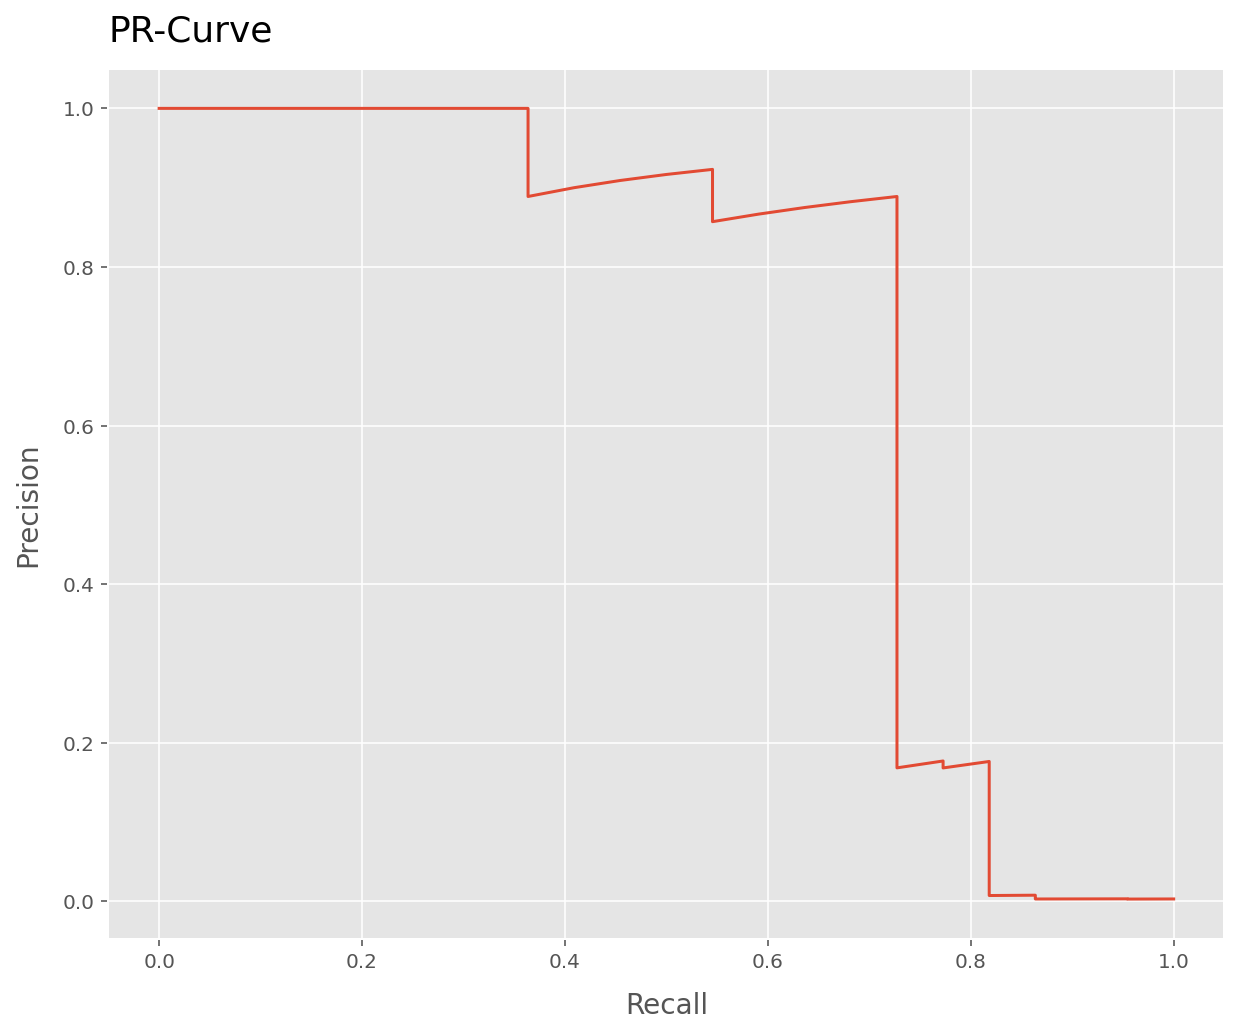

In [109]:
plot_pr_curve(y_test, y_pred_proba)

In [110]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.704
k = 0.744
MCC = 0.744


**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой — оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход — это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [111]:
!pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [25]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак — мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства — скажем, 1:2 и 1:10).

#### Частичное выравнивание




In [221]:
oversampler = SMOTE(sampling_strategy=0.1, random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [222]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

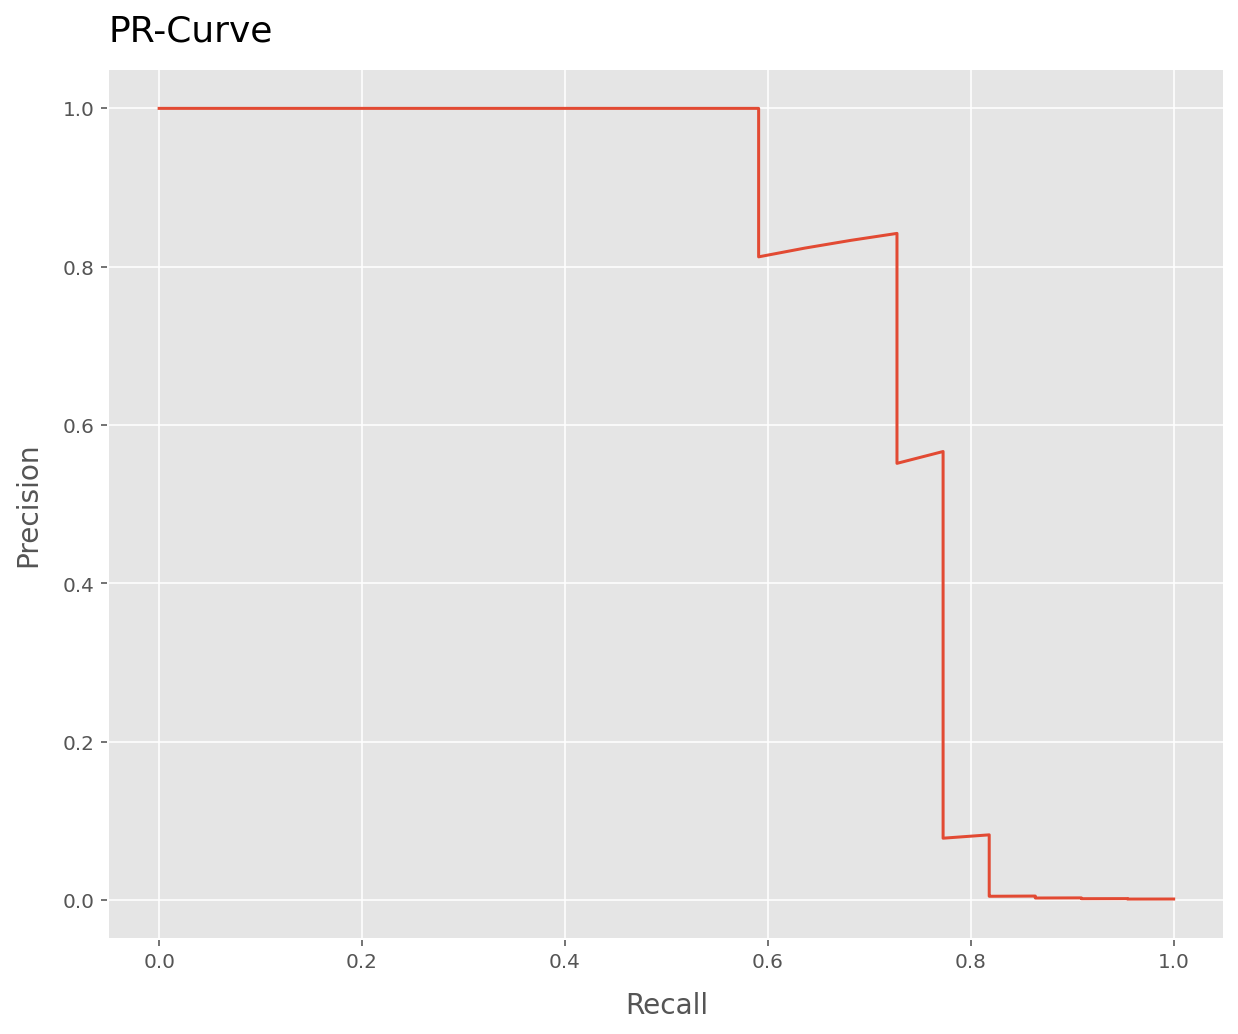

In [223]:
plot_pr_curve(y_test, y_pred_proba)

In [224]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.733
k = 0.744
MCC = 0.744


#### Полное выравнивание 

In [225]:
oversampler = SMOTE(random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [226]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

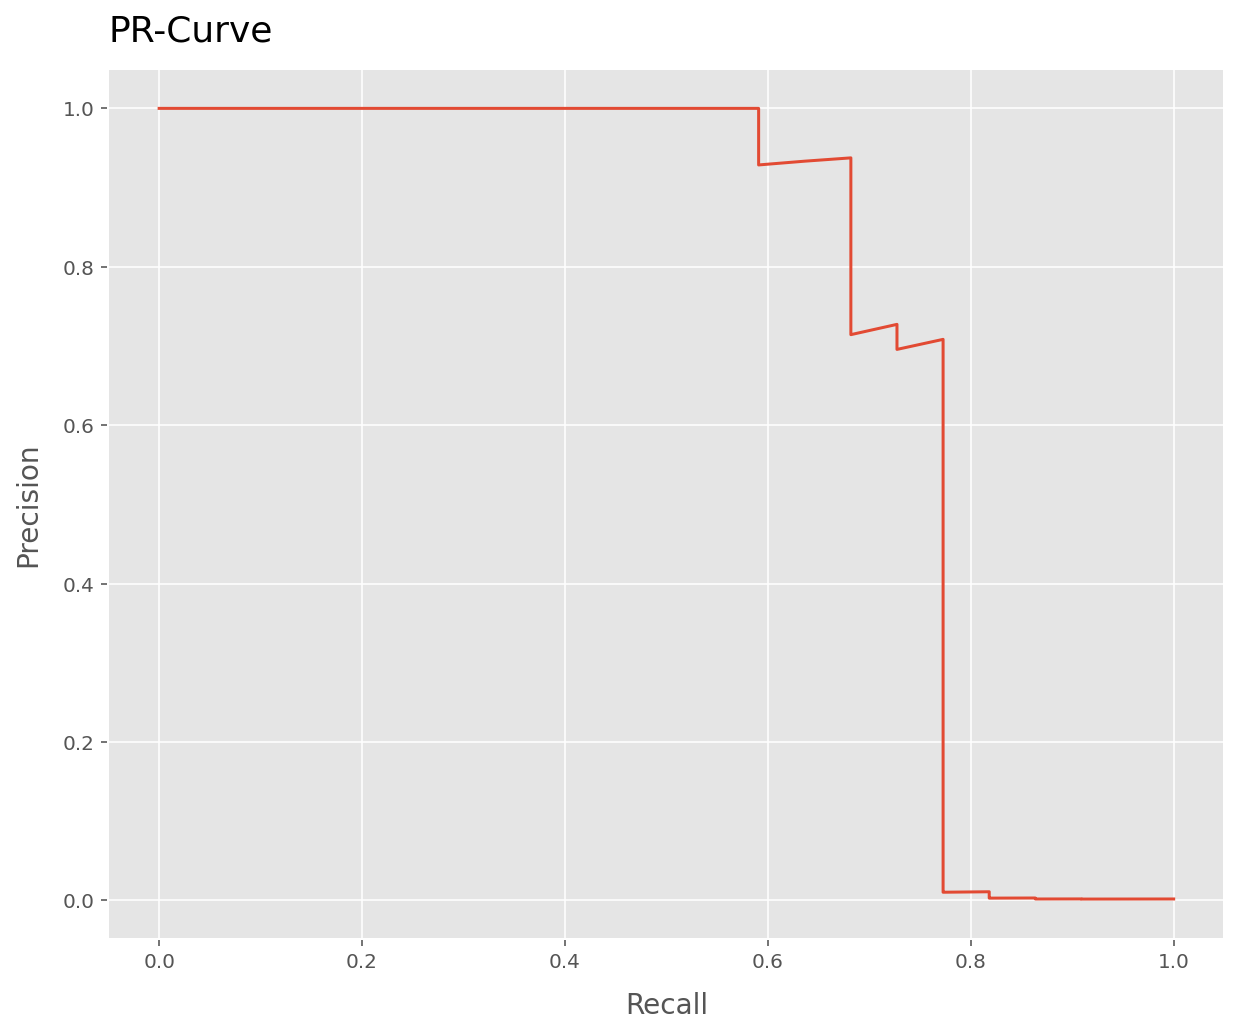

In [227]:
plot_pr_curve(y_test, y_pred_proba)

In [228]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.741
k = 0.723
MCC = 0.725


**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это, смог понять):

#### BorderlineSMOTE



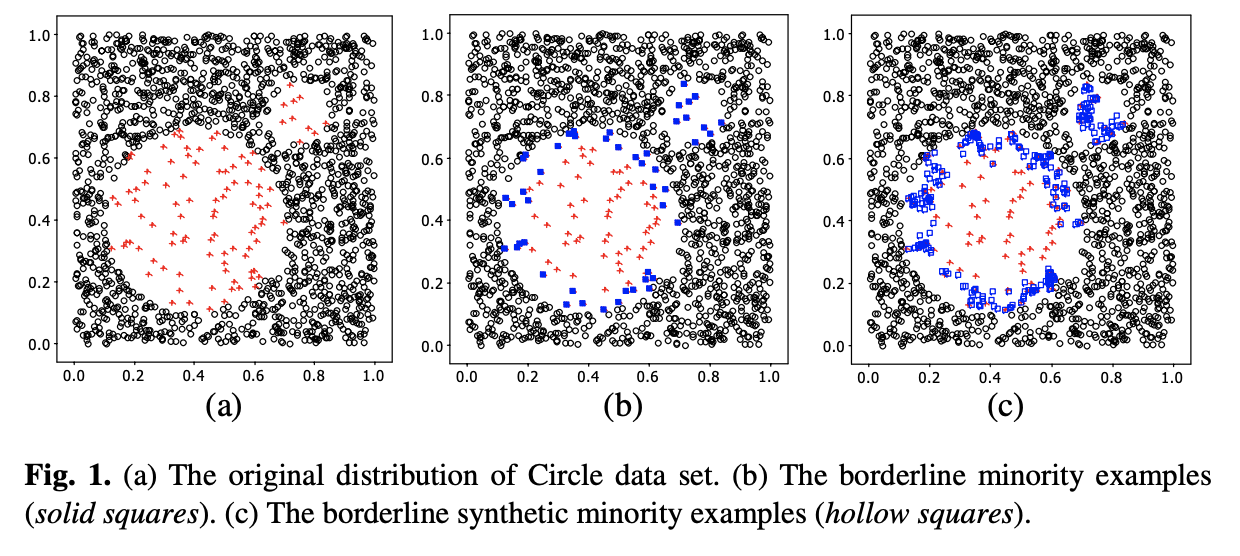



BorderlineSMOTE — метод, генерирующий синтетические объекты минорного класса _только_ на разделяющей границе мажорного и минорного классов. Именно такие объекты влияют на классификационное решение алгоритма.

In [23]:
from imblearn.over_sampling import BorderlineSMOTE

Сначала применим частичное выравнивание.

In [233]:
oversampler = BorderlineSMOTE(sampling_strategy=0.1, random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [234]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

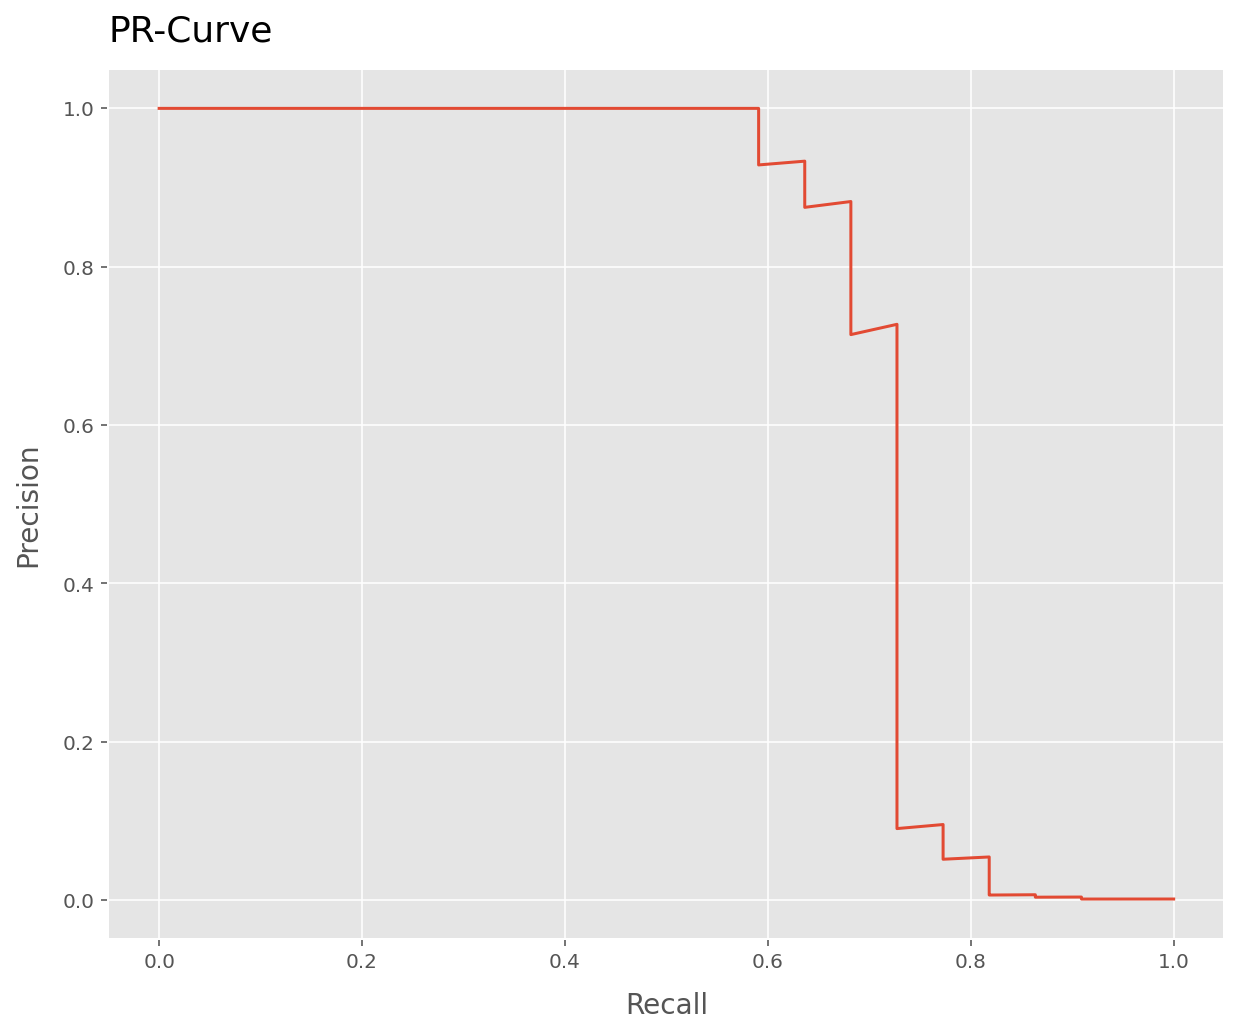

In [235]:
plot_pr_curve(y_test, y_pred_proba)

In [236]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.713
k = 0.711
MCC = 0.711


Теперь полное выравнивание.

In [229]:
oversampler = BorderlineSMOTE(random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [230]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

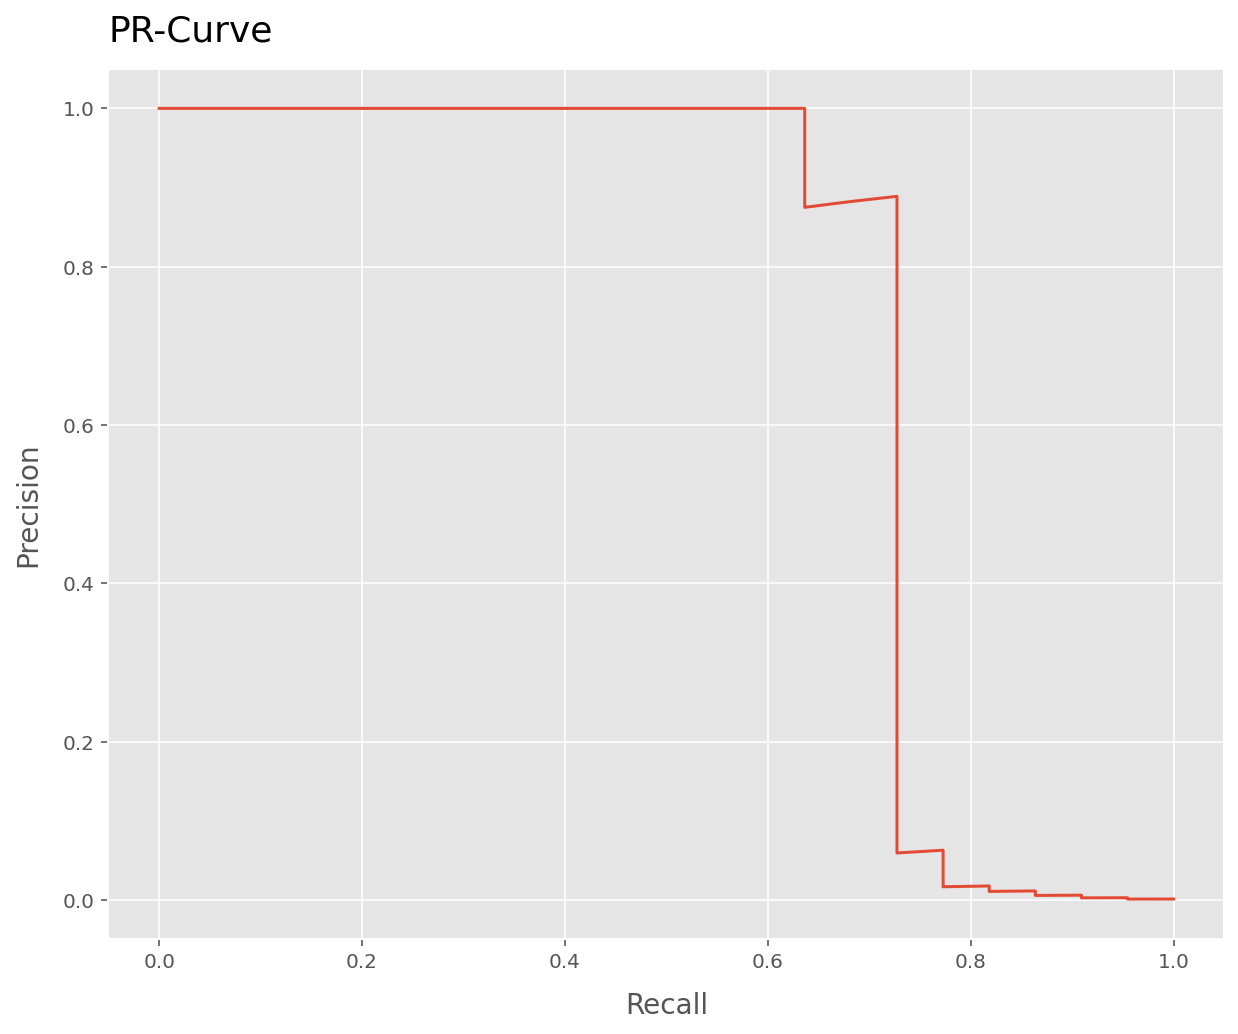

In [231]:
plot_pr_curve(y_test, y_pred_proba)

In [232]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.721
k = 0.744
MCC = 0.744


#### SVM-SMOTE
SVM-SMOTE — это BorderlineSMOTE, где вместо kNN используется SVM для определения разделяющей границы.

Частичное выравнивание.

In [237]:
oversampler = SMOTE(sampling_strategy=0.1, kind='svm', random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [238]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

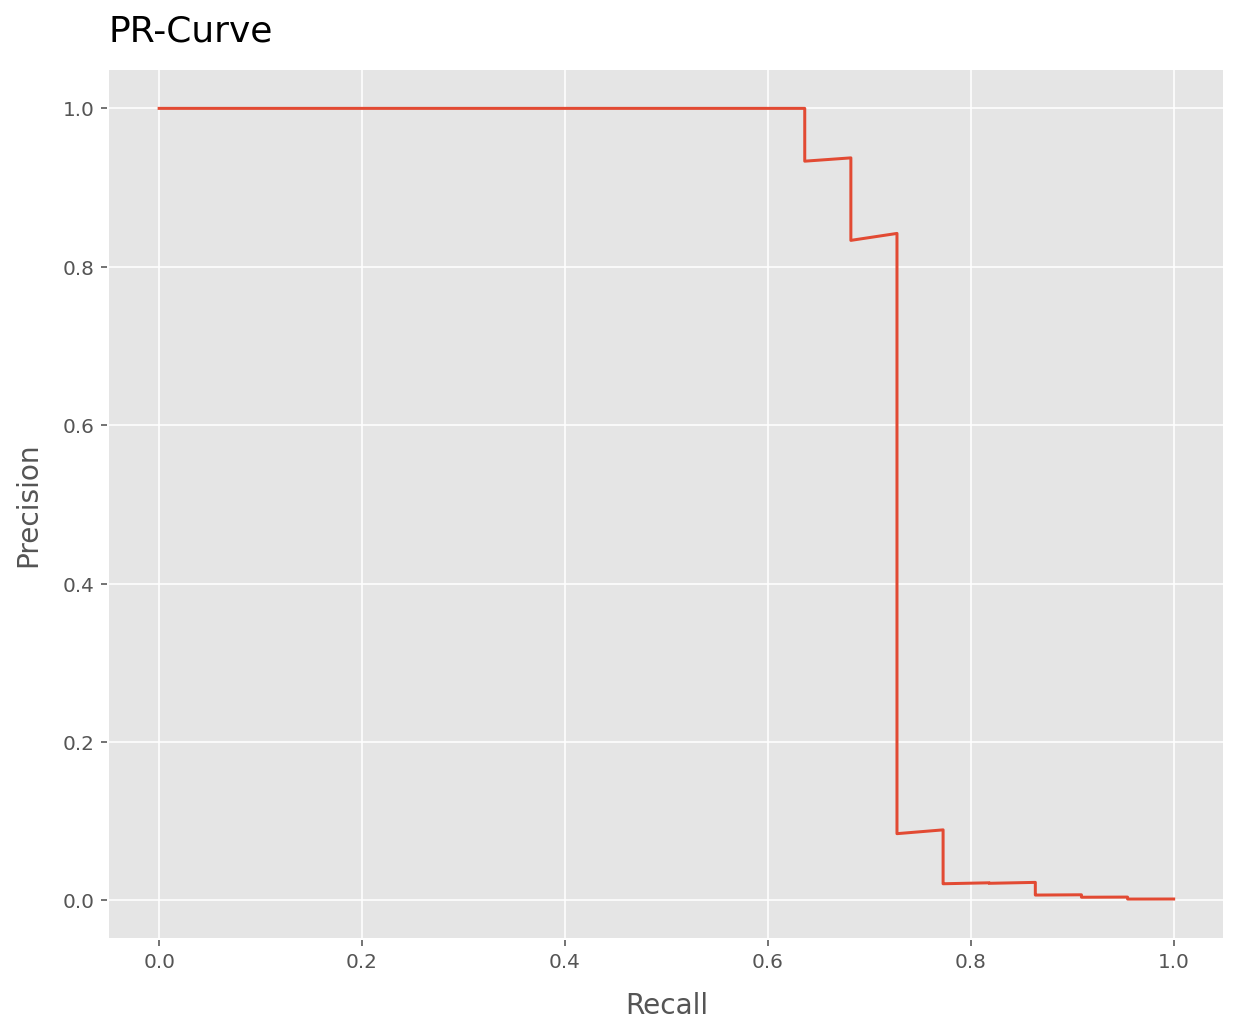

In [239]:
plot_pr_curve(y_test, y_pred_proba)

In [240]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.723
k = 0.711
MCC = 0.711


Полное выравнивание.

In [241]:
oversampler = SMOTE(kind='svm', random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [242]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

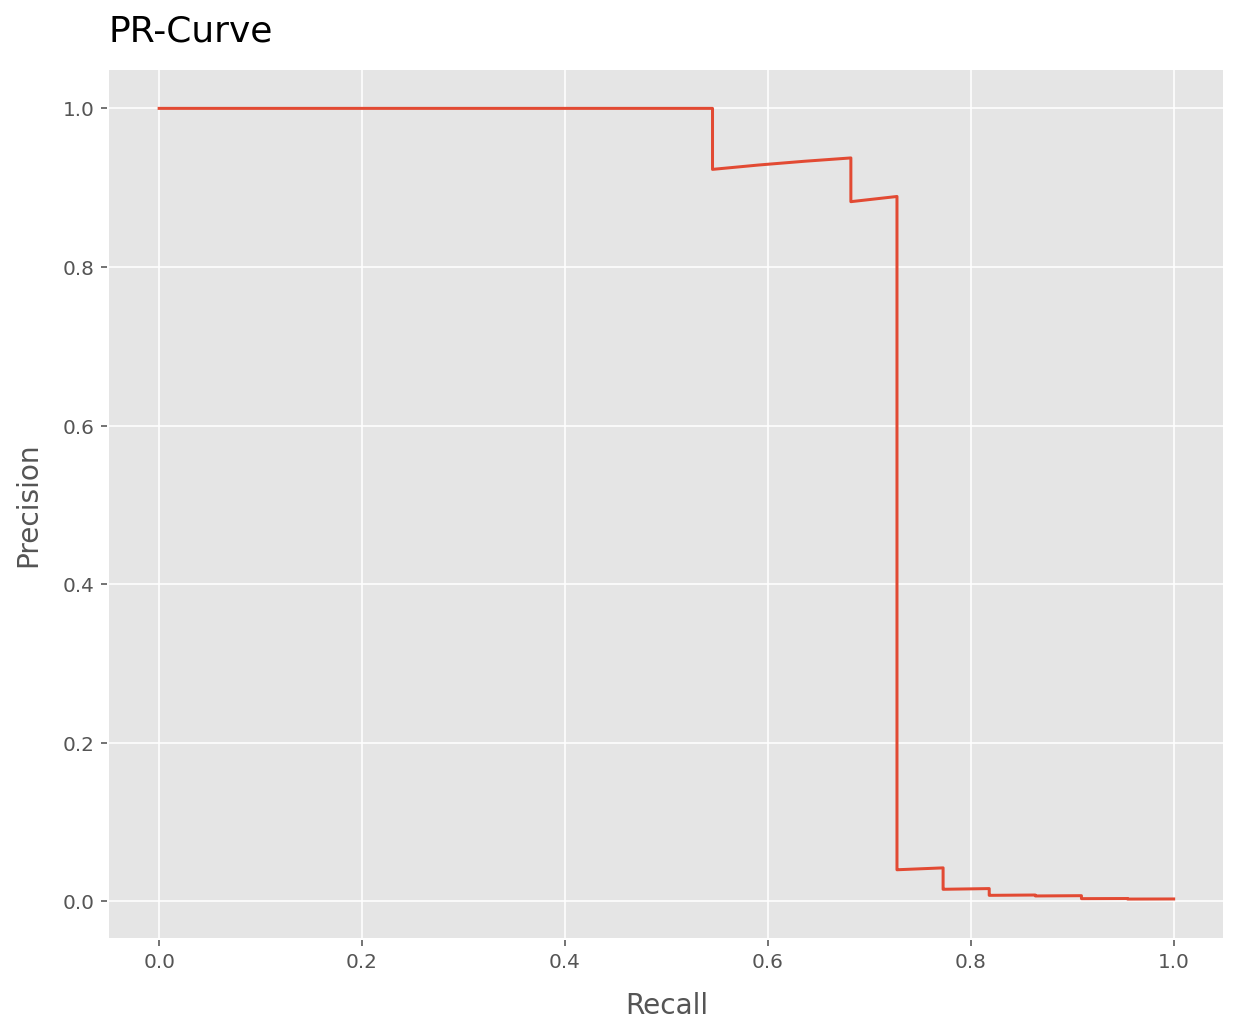

In [243]:
plot_pr_curve(y_test, y_pred_proba)

In [244]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.716
k = 0.681
MCC = 0.682


#### K-Means-SMOTE
K-Means-SMOTE — метод, который делает три последовательных шага:

1) Разбивает выборку на $k$ кластеров.

2) Определяет кластеры с высокой долей минорных классов.

3) Используем SMOTE в выбранных кластерах.


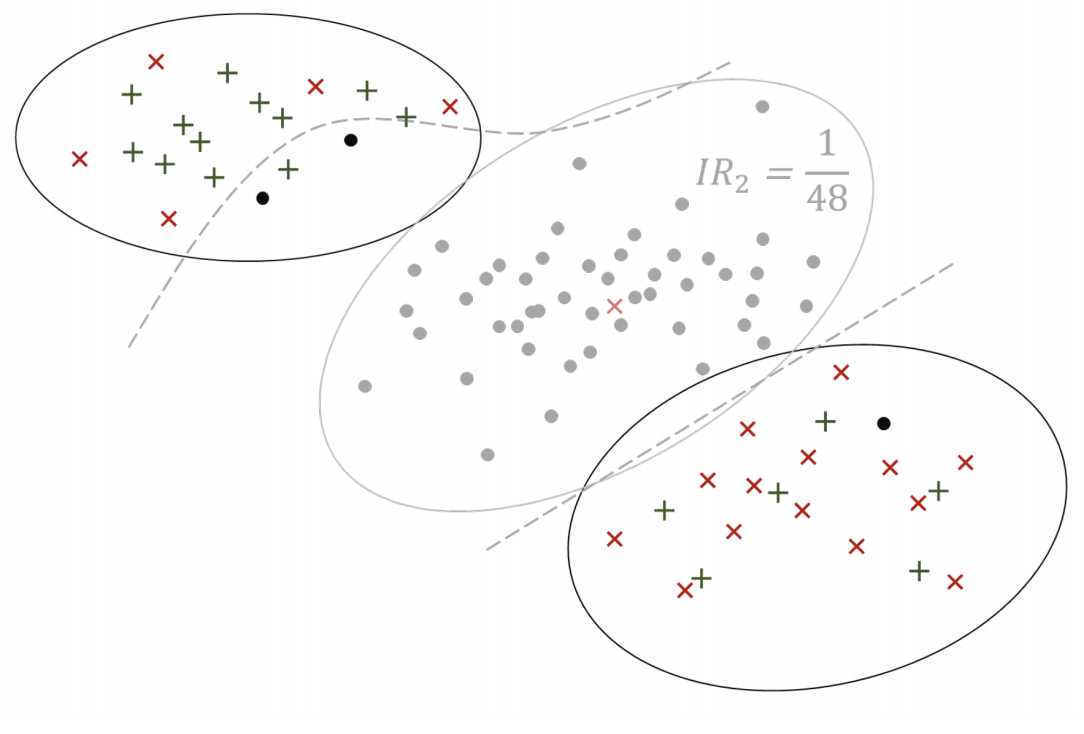

где красные крестики — минорные объекты, точки — мажорные объекты, а зеленые плюсики — синтетические минорные объекты

In [ ]:
!pip install kmeans-smote

In [ ]:
from kmeans_smote import KMeansSMOTE

Частичное выравнивание.

In [ ]:
oversampler = KMeansSMOTE(kmeans_args={'n_clusters': 10}, smote_args={'k_neighbors': 3}, 
                           imbalance_ratio_threshold=0.1)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [ ]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

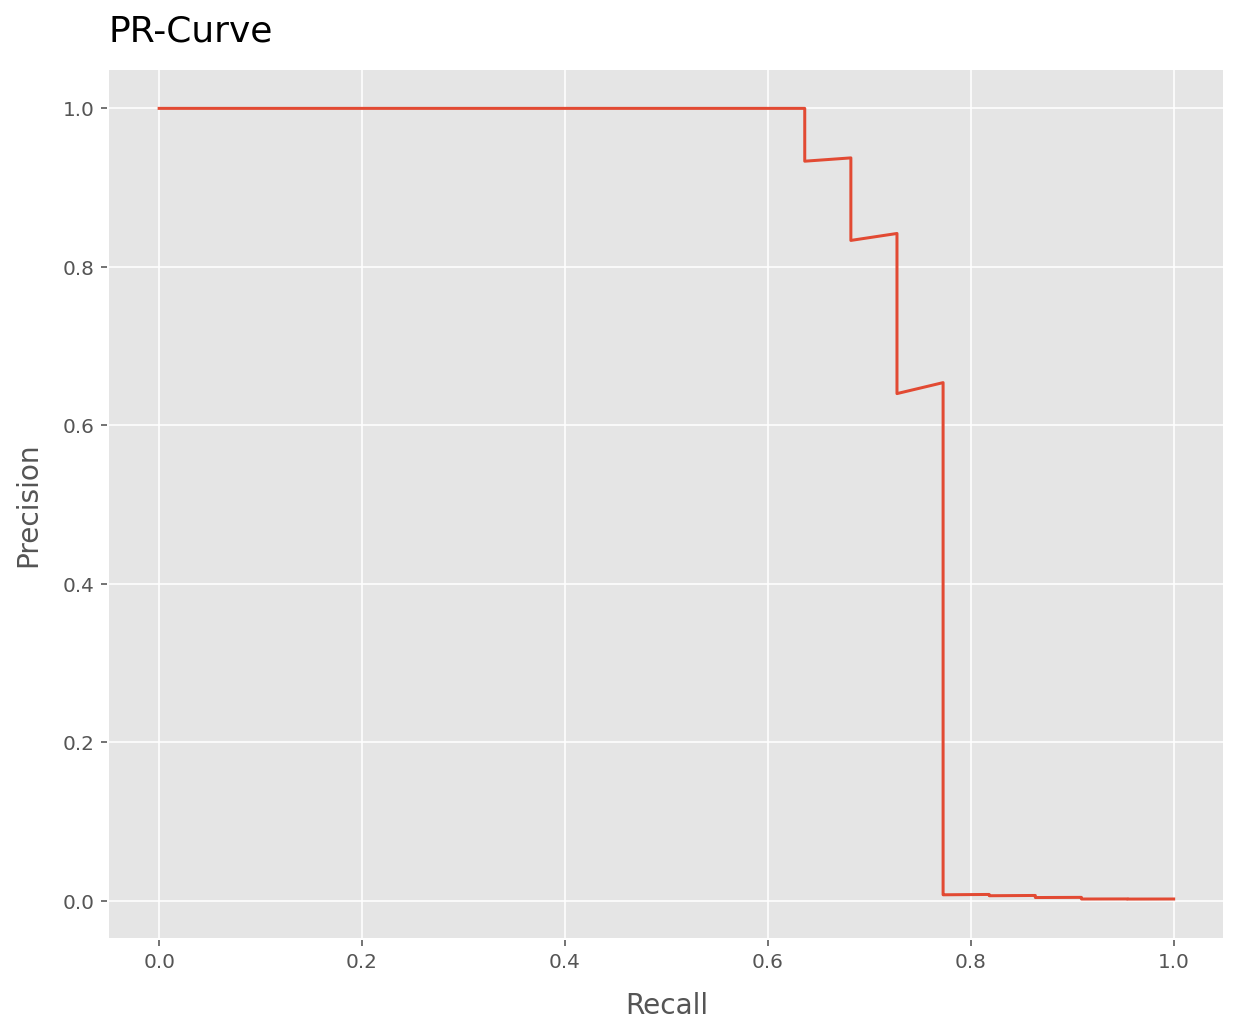

In [ ]:
plot_pr_curve(y_test, y_pred_proba)

In [ ]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.747
k = 0.727
MCC = 0.727


Полное выравнивание.

In [ ]:
oversvampler = KMeansSMOTE(kmeans_args={'n_clusters': 10}, smote_args={'k_neighbors': 3})
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [ ]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

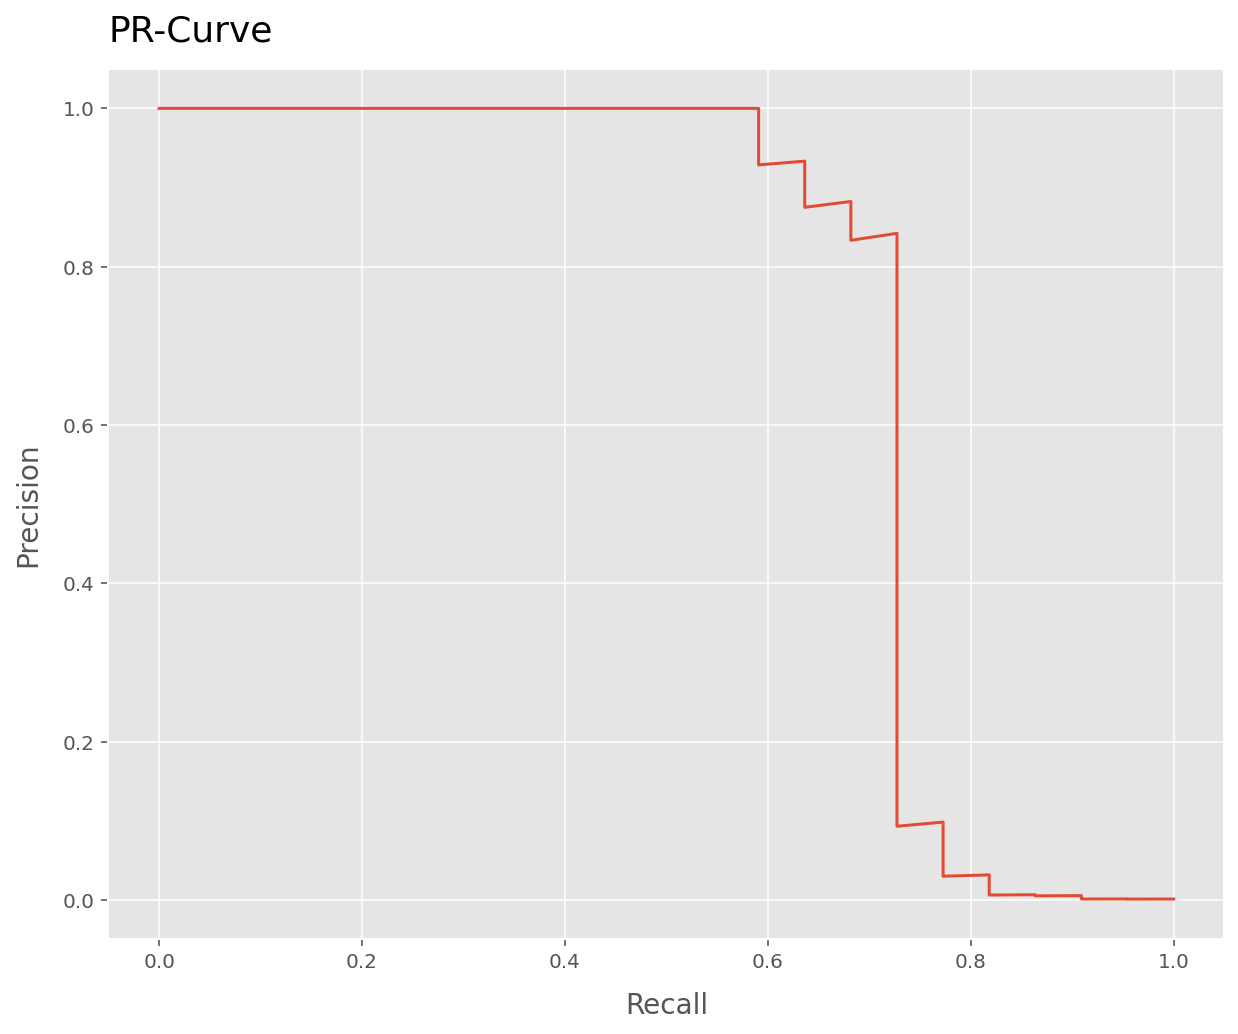

In [ ]:
plot_pr_curve(y_test, y_pred_proba)

In [ ]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.718
k = 0.666
MCC = 0.669


#### ADASYN
ADASYN — плотностный метод, автоматически определяющий необходимое количество синтетических объектов, которые необходимо сгенерировать для
каждого минорного класса. 

In [154]:
from imblearn.over_sampling import ADASYN

In [245]:
oversvampler = ADASYN(random_state=77)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
X_train_over_scaled = scaler.fit_transform(X_train_over)
catboost_clf.fit(X_train_over_scaled, y_train_over);

In [246]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]

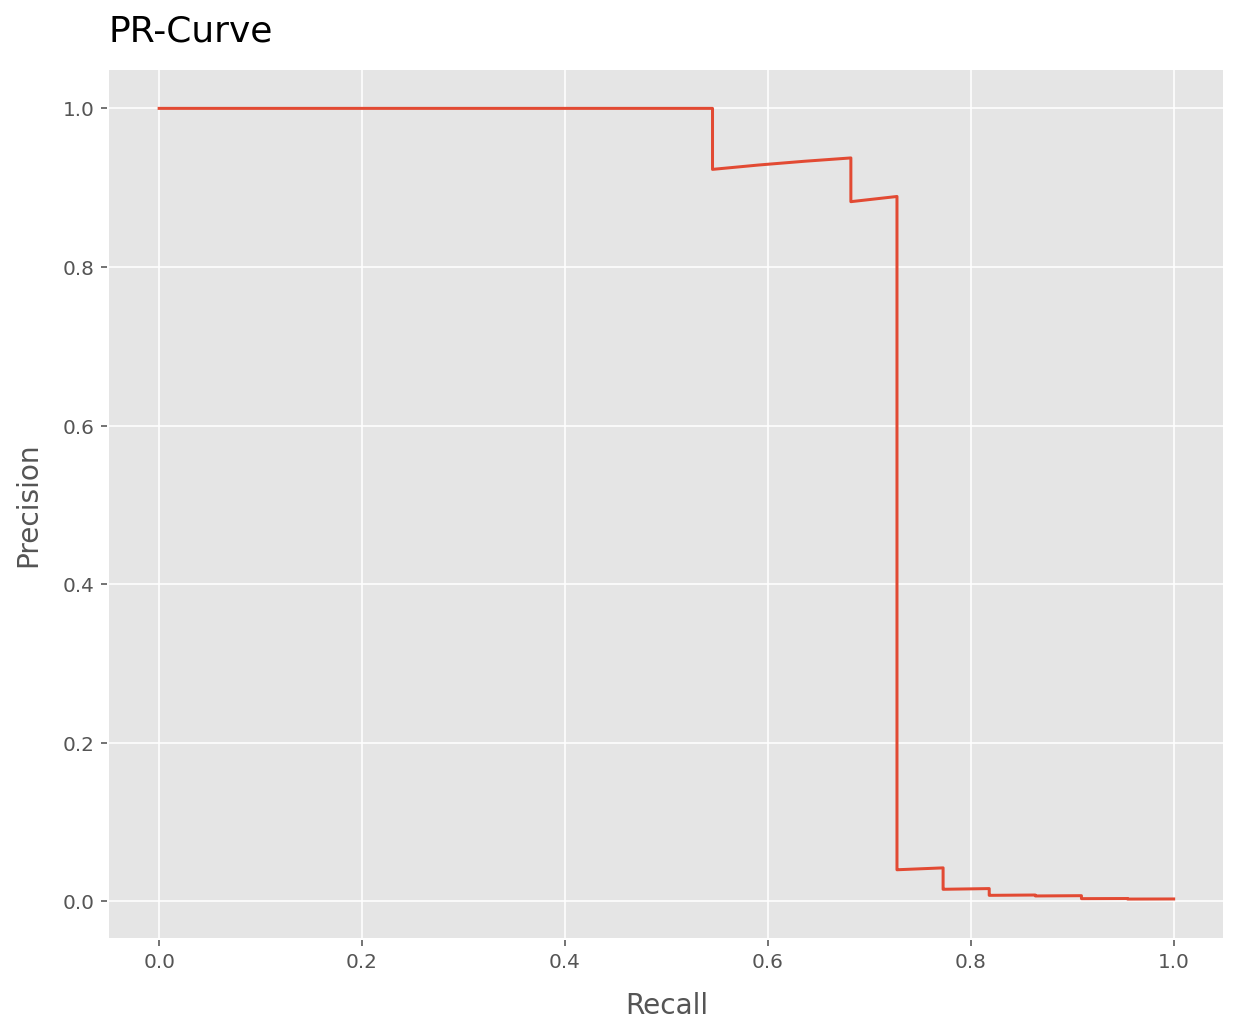

In [247]:
plot_pr_curve(y_test, y_pred_proba)

In [248]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.716
k = 0.681
MCC = 0.682


**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать — удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [159]:
from imblearn.under_sampling import RandomUnderSampler

In [249]:
proportions = np.hstack(np.arange(0.005, 1.005, 0.005))

auc_prs = []
cohen_kappa_scores = []
matthews_corrcoefs = []

old_to_new_ratio = []

for proportion in tqdm(proportions):
    undersampler = RandomUnderSampler(sampling_strategy=proportion, random_state=77)
    X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
    X_train_under_scaled = scaler.fit_transform(X_train_under)
    X_test_scaled = scaler.transform(X_test)

    old_to_new_ratio.append(len(y_train) / len(y_train_under))

    catboost_clf.fit(X_train_under_scaled, y_train_under)

    y_pred = catboost_clf.predict(X_test_scaled)
    y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    auc_prs.append(auc(recall, precision))
    cohen_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    matthews_corrcoefs.append(matthews_corrcoef(y_test, y_pred))

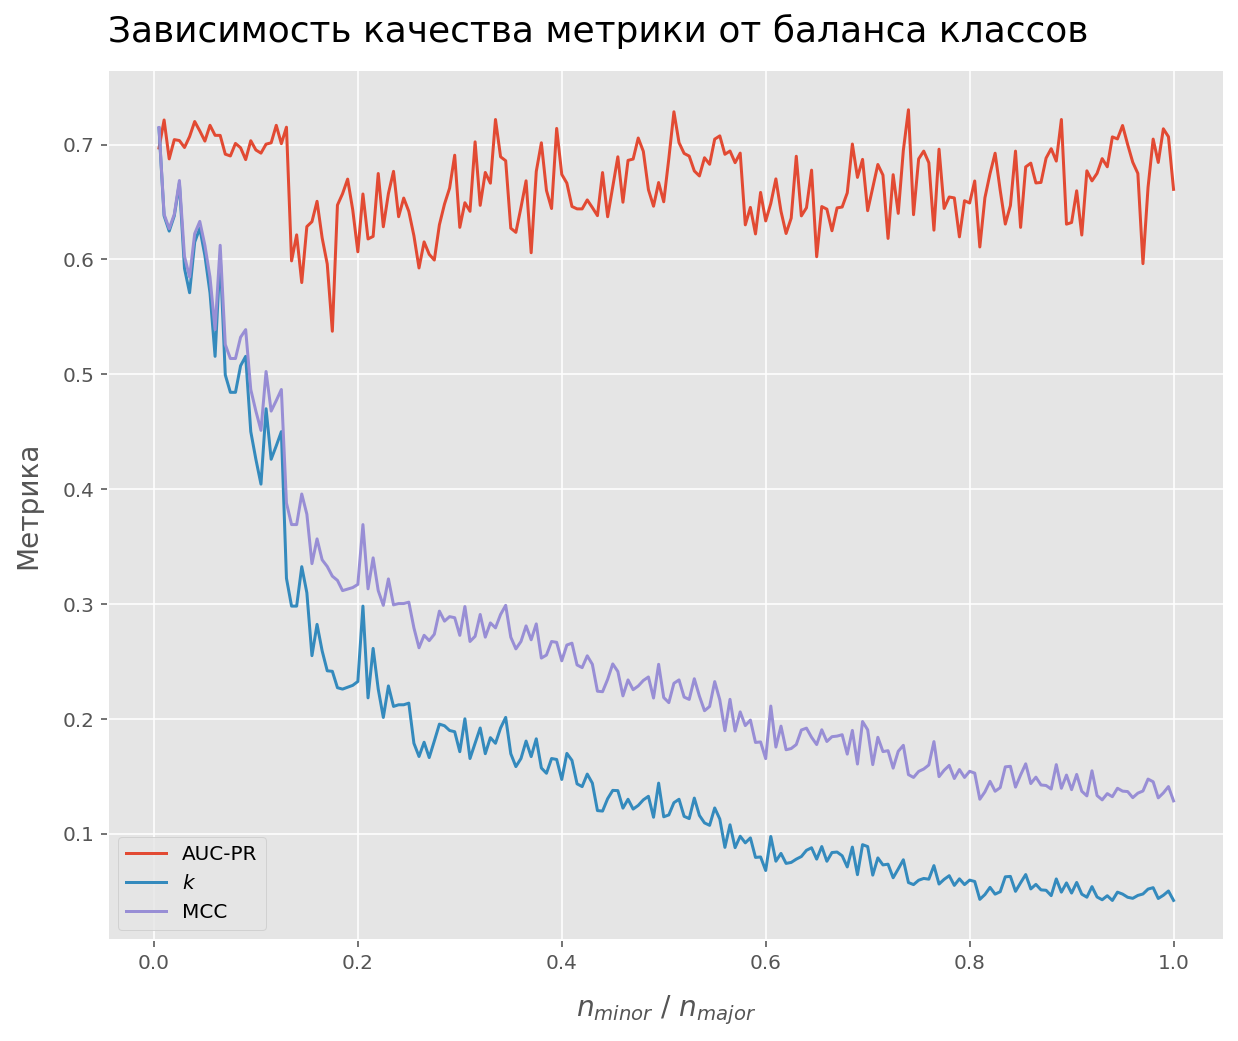

In [250]:
plt.title('Зависимость качества метрики от баланса классов', pad=14, fontsize=18, loc='left')
plt.xlabel('$n_{minor}$ / $n_{major}$', labelpad=10, fontsize=14)
plt.ylabel('Метрика', labelpad=10, fontsize=14)

plt.plot(proportions, auc_prs, label='AUC-PR')
plt.plot(proportions, cohen_kappa_scores, label='$k$')
plt.plot(proportions, matthews_corrcoefs, label='MCC')

plt.legend();

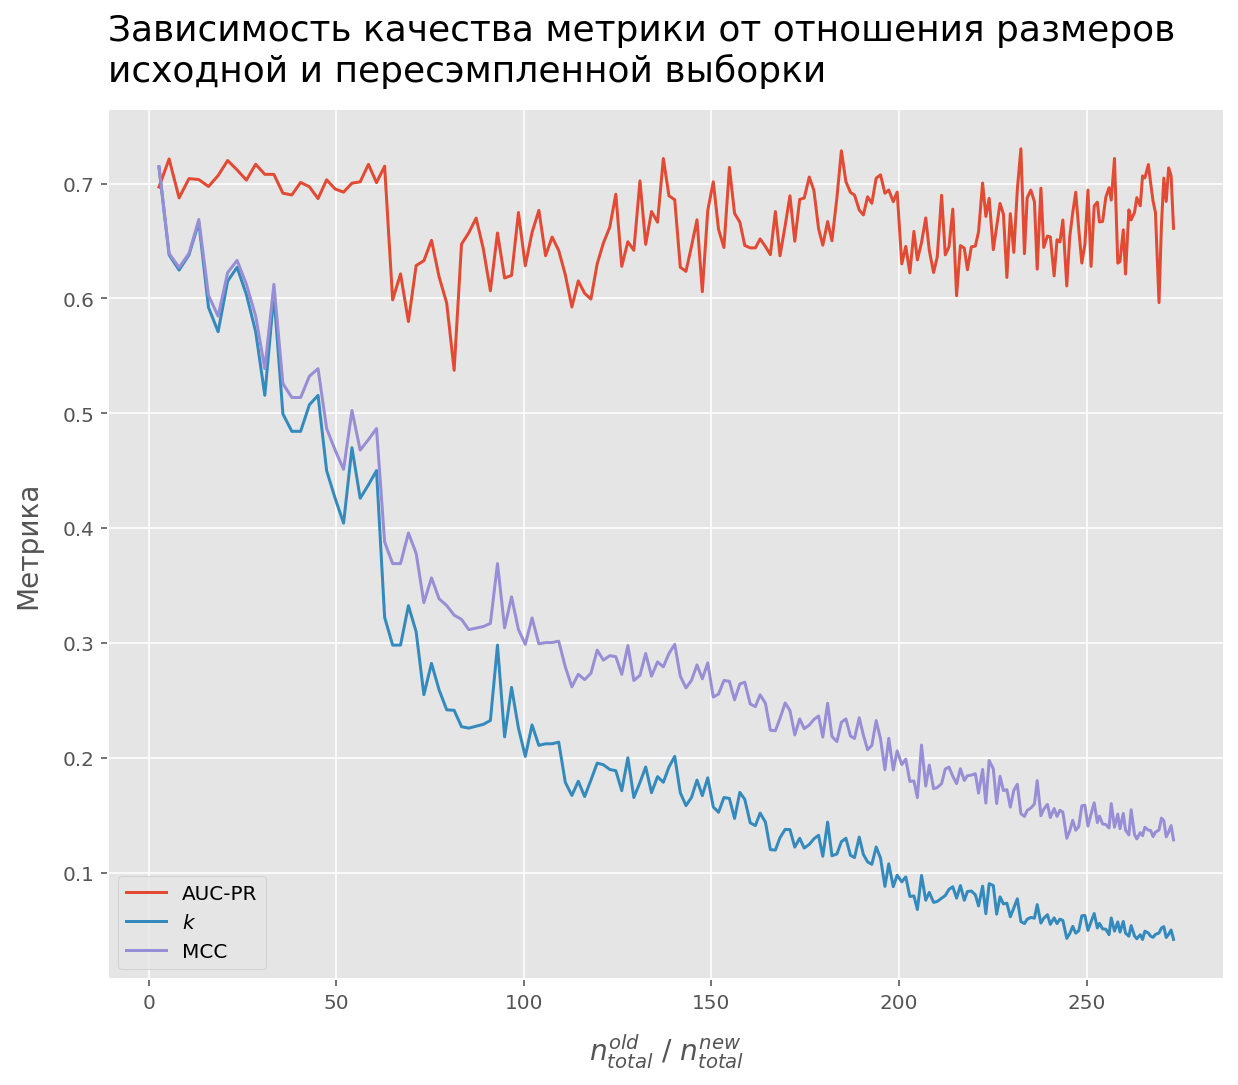

In [251]:
plt.title('Зависимость качества метрики от отношения размеров\nисходной и пересэмпленной выборки', pad=14, fontsize=18, loc='left')
plt.xlabel('$n^{old}_{total}$ / $n^{new}_{total}$', labelpad=10, fontsize=14)
plt.ylabel('Метрика', labelpad=10, fontsize=14)

plt.plot(old_to_new_ratio, auc_prs, label='AUC-PR')
plt.plot(old_to_new_ratio, cohen_kappa_scores, label='$k$')
plt.plot(old_to_new_ratio, matthews_corrcoefs, label='MCC')

plt.legend();

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество — например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [252]:
from imblearn.under_sampling import NearMiss

In [259]:
n_neighbors = np.arange(2, 20)

auc_prs = []
cohen_kappa_scores = []
matthews_corrcoefs = []

for n in tqdm(n_neighbors):
    undersampler = NearMiss(n_neighbors=n, random_state=77)
    X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
    X_train_under_scaled = scaler.fit_transform(X_train_under)
    X_test_scaled = scaler.transform(X_test)

    catboost_clf.fit(X_train_under_scaled, y_train_under)

    y_pred = catboost_clf.predict(X_test_scaled)
    y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    auc_prs.append(auc(recall, precision))
    cohen_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    matthews_corrcoefs.append(matthews_corrcoef(y_test, y_pred))

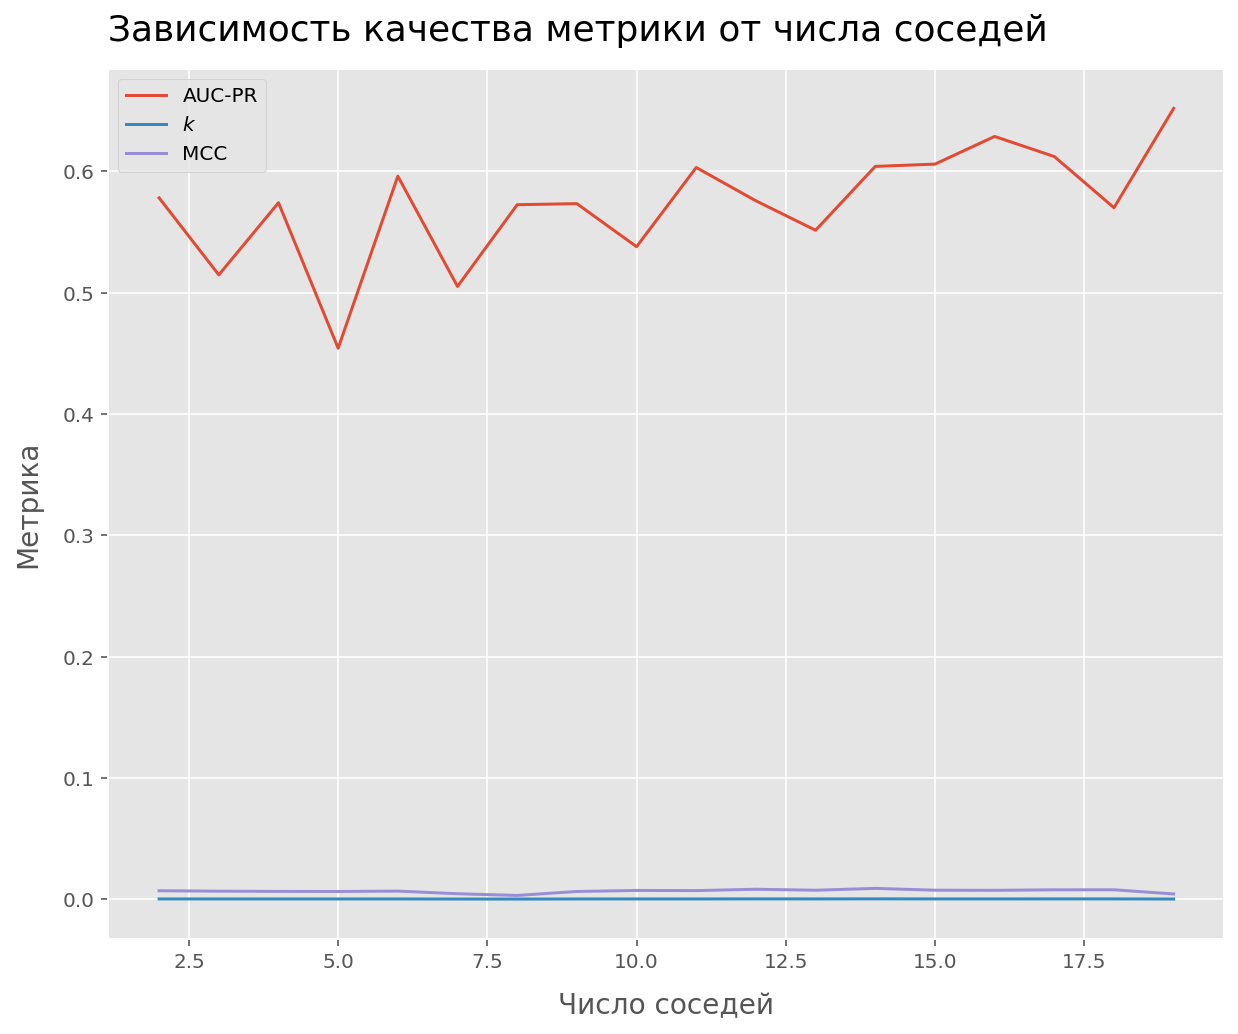

In [260]:
plt.title('Зависимость качества метрики от числа соседей', pad=14, fontsize=18, loc='left')
plt.xlabel('Число соседей', labelpad=10, fontsize=14)
plt.ylabel('Метрика', labelpad=10, fontsize=14)

plt.plot(n_neighbors_ver3, auc_prs, label='AUC-PR')
plt.plot(n_neighbors_ver3, cohen_kappa_scores, label='$k$')
plt.plot(n_neighbors_ver3, matthews_corrcoefs, label='MCC')

plt.legend();

In [262]:
proportions = np.hstack(np.arange(0.005, 1.005, 0.005))

auc_prs = []
cohen_kappa_scores = []
matthews_corrcoefs = []

old_to_new_ratio = []

for proportion in tqdm(proportions):
    undersampler = NearMiss(sampling_strategy=proportion, n_neighbors=18, 
                            random_state=77)
    X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
    X_train_under_scaled = scaler.fit_transform(X_train_under)
    X_test_scaled = scaler.transform(X_test)

    old_to_new_ratio.append(len(y_train) / len(y_train_under))

    catboost_clf.fit(X_train_under_scaled, y_train_under)

    y_pred = catboost_clf.predict(X_test_scaled)
    y_pred_proba = catboost_clf.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    auc_prs.append(auc(recall, precision))
    cohen_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    matthews_corrcoefs.append(matthews_corrcoef(y_test, y_pred))

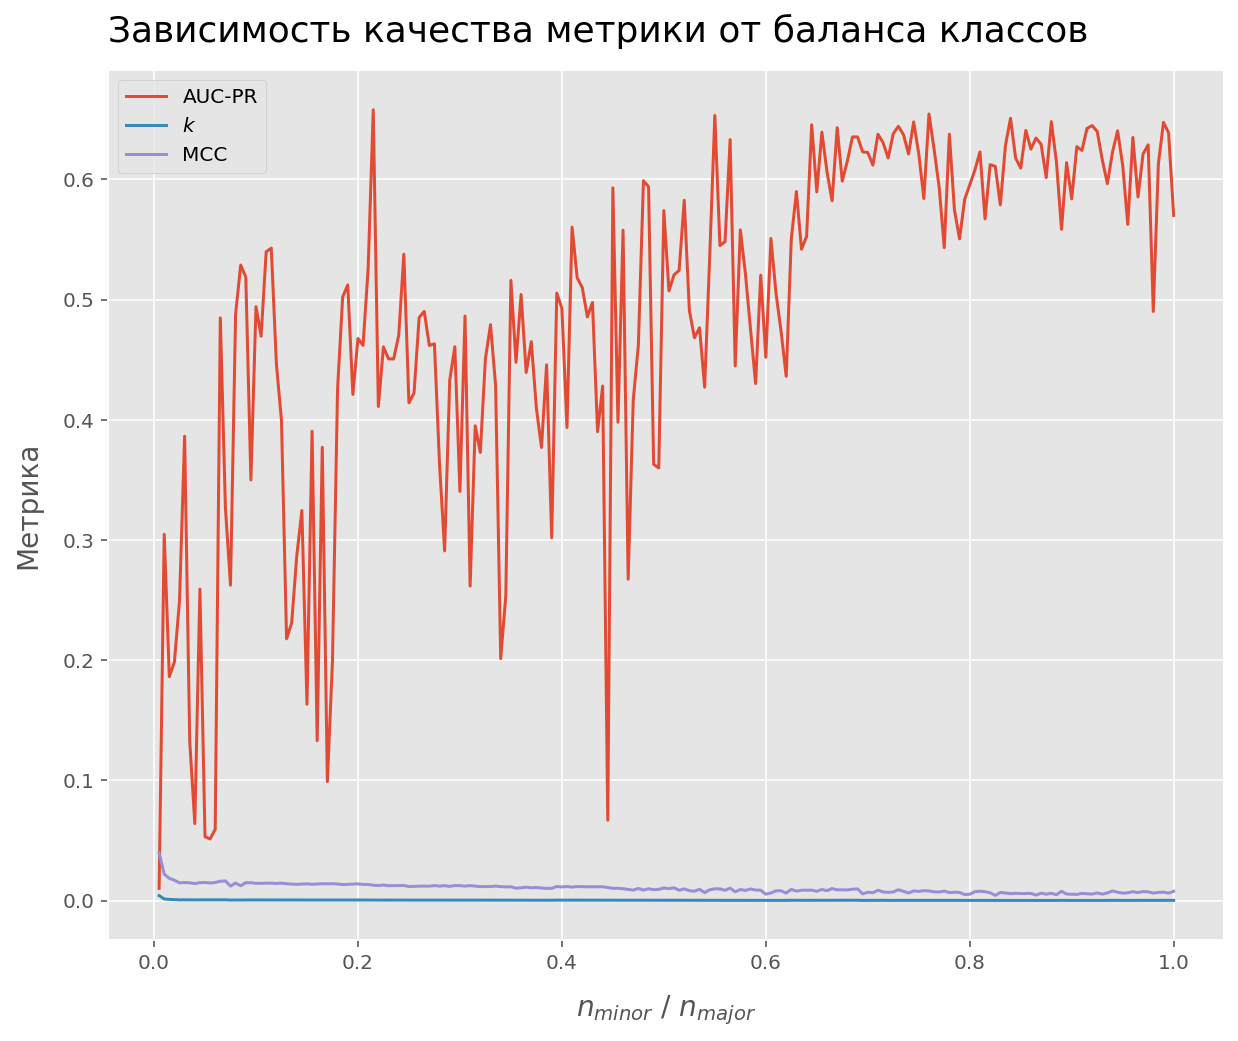

In [263]:
plt.title('Зависимость качества метрики от баланса классов', pad=14, fontsize=18, loc='left')
plt.xlabel('$n_{minor}$ / $n_{major}$', labelpad=10, fontsize=14)
plt.ylabel('Метрика', labelpad=10, fontsize=14)

plt.plot(proportions, auc_prs, label='AUC-PR')
plt.plot(proportions, cohen_kappa_scores, label='$k$')
plt.plot(proportions, matthews_corrcoefs, label='MCC')

plt.legend();

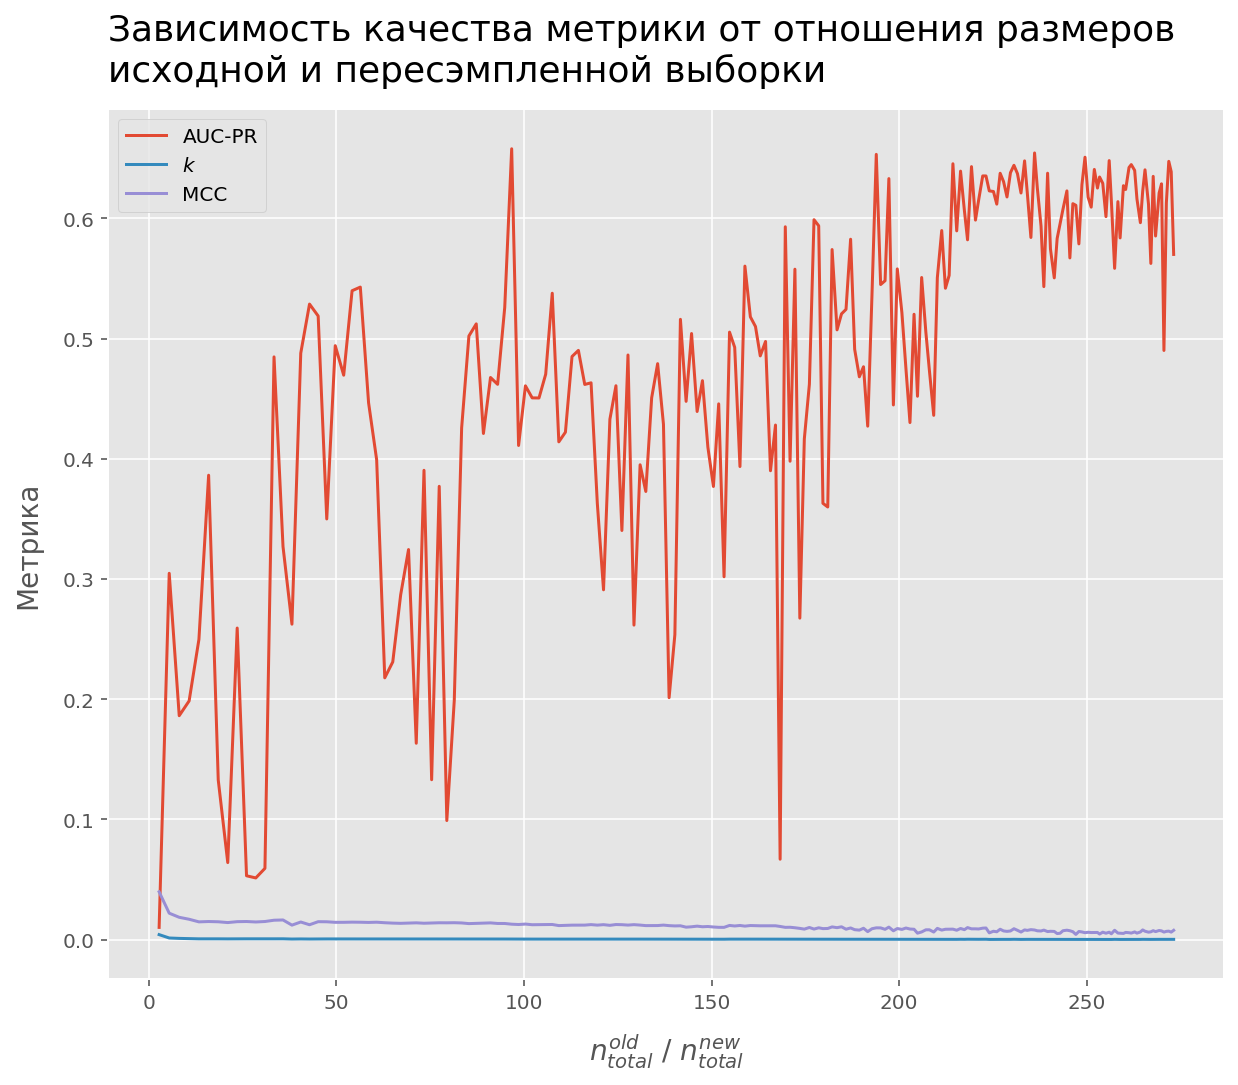

In [264]:
plt.title('Зависимость качества метрики от отношения размеров \nисходной и пересэмпленной выборки', pad=14, fontsize=18, loc='left')
plt.xlabel('$n^{old}_{total}$ / $n^{new}_{total}$', labelpad=10, fontsize=14)
plt.ylabel('Метрика', labelpad=10, fontsize=14)

plt.plot(old_to_new_ratio, auc_prs, label='AUC-PR')
plt.plot(old_to_new_ratio, cohen_kappa_scores, label='$k$')
plt.plot(old_to_new_ratio, matthews_corrcoefs, label='MCC')

plt.legend();

__Вывод__: данные методы андерсэмплинга работают намного хуже оверсэмплинга.

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

#### EditedNearestNeighbours

EditedNearestNeighbours — метод, который удаляет объекты, близко лежащие к разделяющей границе классов (decision boundary).

In [24]:
 from imblearn.under_sampling import EditedNearestNeighbours

In [266]:
undersampler = EditedNearestNeighbours(sampling_strategy='not minority', random_state=77)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
X_train_under_scaled = scaler.fit_transform(X_train_under)
catboost_clf.fit(X_train_under_scaled, y_train_under);

In [267]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test)[:, 1]

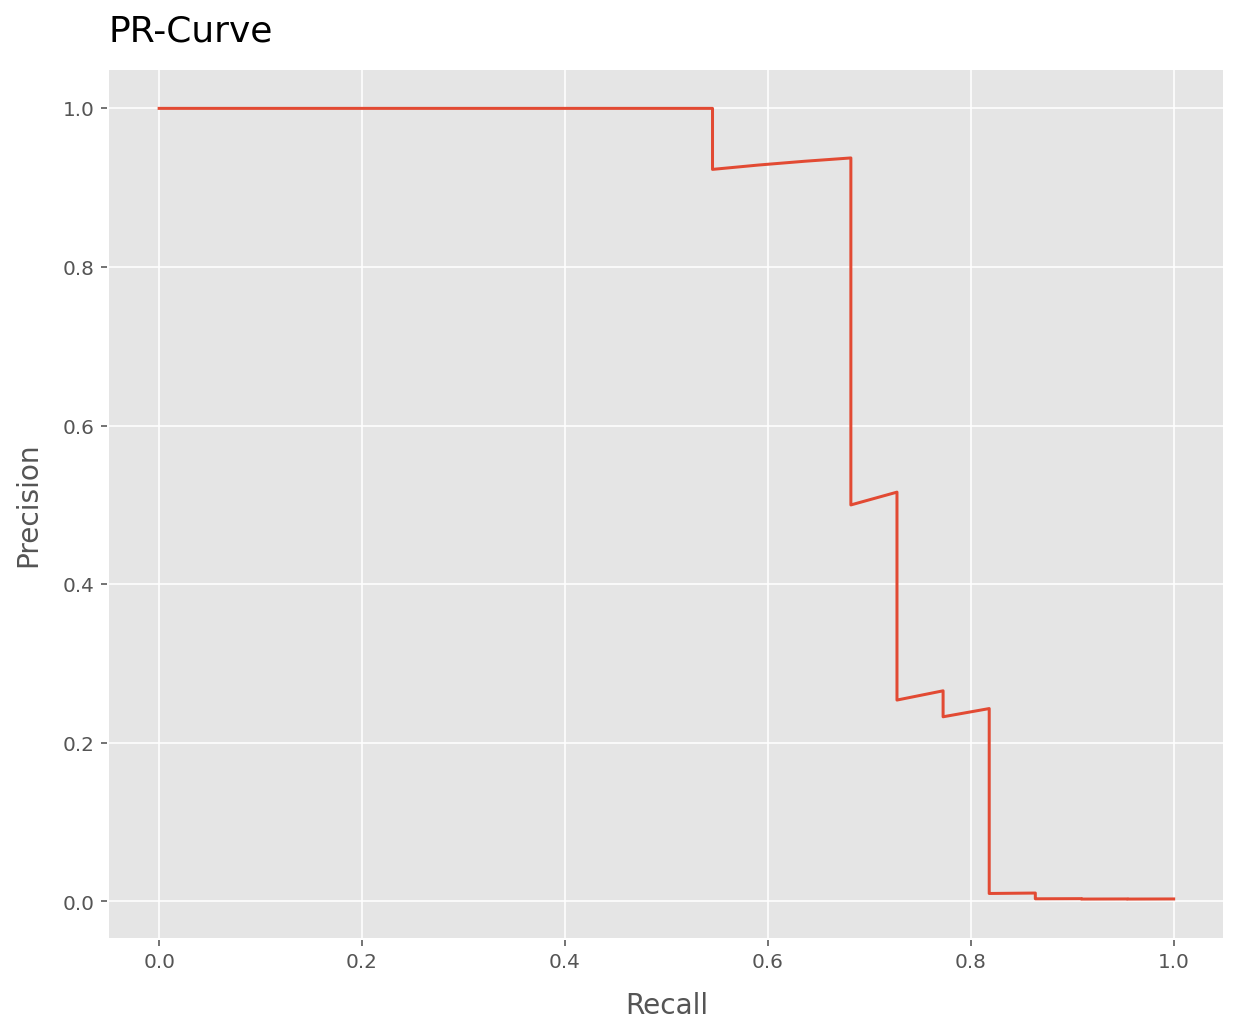

In [268]:
plot_pr_curve(y_test, y_pred_proba)

In [269]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.719
k = 0.75
MCC = 0.754


#### AllKNN

AllKNN — это ENN, который применяется несколько раз с разным числом соседей.

In [25]:
from imblearn.under_sampling import AllKNN

In [271]:
undersampler = AllKNN(sampling_strategy='not minority', random_state=77)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
X_train_under_scaled = scaler.fit_transform(X_train_under)
catboost_clf.fit(X_train_under_scaled, y_train_under);

In [272]:
X_test_scaled = scaler.transform(X_test)
y_pred = catboost_clf.predict(X_test_scaled)
y_pred_proba = catboost_clf.predict_proba(X_test)[:, 1]

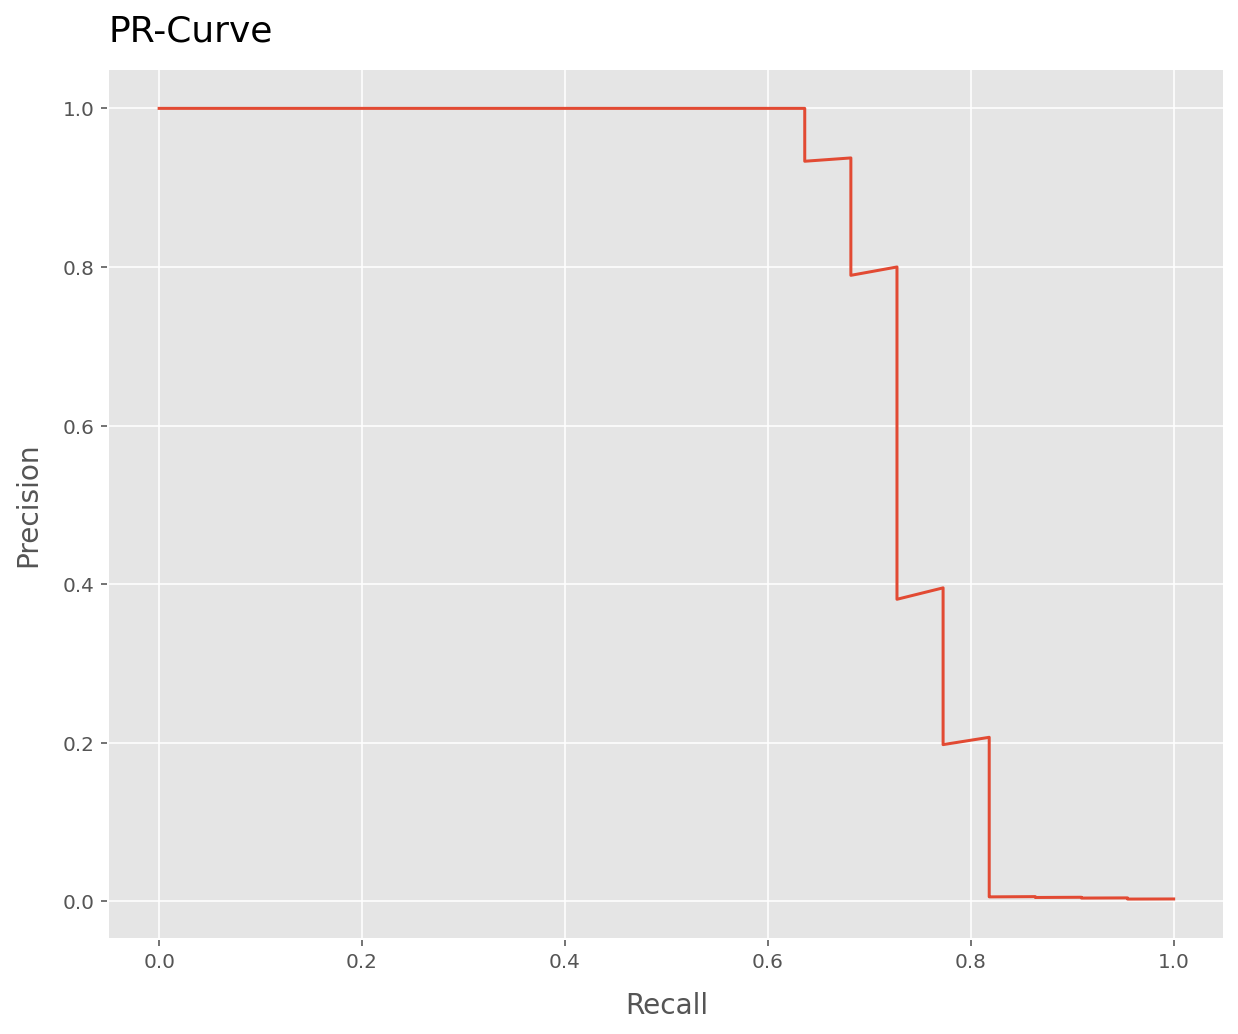

In [273]:
plot_pr_curve(y_test, y_pred_proba)

In [274]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.743
k = 0.718
MCC = 0.724


**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

#### Простое голосование

In [30]:
answers = []

samplers = [SMOTE(sampling_strategy=0.1, random_state=77), 
            BorderlineSMOTE(random_state=77), 
            EditedNearestNeighbours(sampling_strategy='not minority', random_state=77),
            AllKNN(sampling_strategy='not minority', random_state=77)]

In [32]:
for sampler in samplers:
    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
    X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
    X_test_scaled = scaler.transform(X_test)

    catboost_clf.fit(X_train_sampled_scaled, y_train_sampled)
    answers.append(catboost_clf.predict(X_test_scaled))

In [48]:
y_pred_proba = (np.vstack(answers).sum(axis=0) / 4) 
y_pred = (y_pred_proba >= 0.5) * 1

In [49]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.754
k = 0.762
MCC = 0.763


Не получилось, попробуем что-то еще.

#### Стекинг

Импортируем мета-классификатор.

In [27]:
from sklearn.ensemble import AdaBoostClassifier

Импортируем базовые классификаторы.

In [28]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

Подберем для них гиперпараметры.

In [148]:
param_test = {'n_estimators': np.arange(100, 1000, 50)}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=77), 
                           param_grid=param_test, 
                           scoring='average_precision',
                           n_jobs=-1,
                           verbose=1, 
                           cv=5)

grid_search.fit(X_val, y_val)
grid_search.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.7min finished


{'n_estimators': 950}

In [29]:
random_forest_clf = RandomForestClassifier(random_state=77, n_estimators=950, n_jobs=-1)

In [151]:
param_test = {'n_estimators': np.arange(100, 1000, 50)}

grid_search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=77), 
                           param_grid=param_test, 
                           scoring='average_precision',
                           n_jobs=-1,
                           verbose=1, 
                           cv=5)

grid_search.fit(X_val, y_val)
grid_search.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   45.6s finished


{'n_estimators': 550}

In [30]:
extra_trees_clf = ExtraTreesClassifier(random_state=77, n_estimators=550, n_jobs=-1)

In [202]:
param_test = {'n_estimators': np.arange(100, 1000, 50), 
              'max_depth': np.arange(3, 10)}


grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=77), 
                           param_grid=param_test, 
                           scoring='average_precision',
                           n_jobs=-1,
                           verbose=1, 
                           cv=5)

grid_search.fit(X_val, y_val)
grid_search.best_params_

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  3.1min finished


{'max_depth': 6, 'n_estimators': 100}

In [31]:
 grad_boost_clf = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=77)

In [34]:
train_features = []
test_features = []

y_preds = []

base_models = [catboost_clf, random_forest_clf, extra_trees_clf, grad_boost_clf]

for model in tqdm(base_models):
    model.fit(X_train_scaled, y_train)
    train_features.append(model.predict_proba(X_train_scaled)[:, 1])
    test_features.append(model.predict_proba(X_test_scaled)[:, 1])
    y_preds.append(model.predict(X_test_scaled))

In [35]:
train_features_ = np.column_stack((train_features[0], train_features[1], 
                                  train_features[2]))

test_features_ = np.column_stack((test_features[0], test_features[1], 
                                 test_features[2]))

In [38]:
meta_model = AdaBoostClassifier(random_state=77)
meta_model.fit(train_features_, y_train)
y_pred = meta_model.predict(test_features_)
y_pred_proba = meta_model.predict_proba(test_features_)[:, 1]
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.81
k = 0.789
MCC = 0.799


Ну, почти.

Попробуем сделать простое голосование среди базовых моделей.

In [39]:
y_pred_proba = np.vstack((y_preds)).sum(axis=0) / 4
y_pred = (y_pred_proba >= 0.75) * 1
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.767
k = 0.811
MCC = 0.826


Ну, почти.

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных — в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы: мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект: нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков — можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [26]:
def c_factor(n) -> float:
    """
    Computes average path length for an unsuccessful search in a binary search tree.

    Params:
        n: int - number of data points for BST
    """
    if n <= 1:
        return 0
    else:
        return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)

def calc_height(X, depth, node) -> np.ndarray:
    """
    Calculates anomaly scores for sample in a recursive manner.

    Params:
        X: np.array - current sample, available to node
        depth: int - path length up to current node
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    if node.kind == 'external':
        scores = node.depth + c_factor(node.size)
    else:
        mask = ((X - node.b) @ node.w <= 0)
        scores[mask] += calc_height(X[mask], node.depth, node.left) 
        scores[~mask] += calc_height(X[~mask], node.depth, node.right)
        
    return scores

In [27]:
class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        depth: int - depth of node
        left: Node - left child
        right: Node - right child
        kind: str - either "internal" or "external", indicates the type of current node
        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """

    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            left: Node - left child
            right: Node - right child
            kind: str - either "internal" or "external", indicates the type of current node
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"


In [28]:
class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).

    Attributes:
        depth: int - current tree depth
        max_depth: int - maximum tree depth
        root: Node - root node 
        internal_count: int - number of internal nodes
        external_count: int - number of external nodes
    """

    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).

        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth
        """
        self.depth = 0 
        self.max_depth = max_depth 
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"
        
    def grow(self, X, depth) -> Node:
        """
        Grow tree in a recursive manner.

        Params:
            X: np.array - available train sample
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        # Вводим критерий останова: либо в вершине один объект, либо достигнута маскимальная глубина
        if len(X) <= 1 or depth >= self.max_depth:   
            kind = "external"
            self.external_count += 1
            
            w = None
            b = None
            left = None
            right = None
        else:
            kind = "internal"  
            self.internal_count += 1         
            self.depth += 1

            w = np.random.normal(size=X.shape[1])
            min_vals = X.min(axis=0)
            max_vals = X.max(axis=0)
            b = np.random.uniform(min_vals, max_vals)

            mask = ((X - b) @ w <= 0)
            left = self.grow(X[mask], self.depth)
            right = self.grow(X[~mask], self.depth)
            
        return Node(X, depth, left, right, kind, w, b)

    def score_samples(self, X) -> np.ndarray:
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.

        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        scores = calc_height(X, 0, self.root)

        return scores

In [29]:
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.

    Attributes:
        n_trees: int - number of Randomized Trees
        max_depth: int - maximum depth of each tree
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        trees: list - container for trained trees 
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.

        Params:
            n_trees: int - number of Randomized Trees
            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided
            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.

        Params:
            X: np.array - 2d array of samples
        """
        for _ in range(self.n_trees):
            rows = np.arange(X.shape[0])
            sample_size = round(self.subsample_rate * X.shape[0])
            rows_chosen = np.random.choice(rows, size=sample_size, replace=False)

            X_sampled = X[rows_chosen, :]
            random_tree = RandomizedTree(X_sampled, self.max_depth)
            self.trees.append(random_tree)

        self.is_fit = True
            
        return self
    
    def score_samples(self, X) -> np.ndarray:
        """
        Estimate (normalized) anomaly score for each given sample.

        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        scores_overall = np.zeros(X.shape[0])

        for tree in self.trees:
            scores_overall += tree.score_samples(X)
        
        scores = 2 ** ((- scores_overall / self.n_trees) / c_factor(X.shape[0]))

        return scores

    
    def predict(self, X):
        """
        Predict if given samples are outliers.

        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        idxs = np.arange(X.shape[0]) 
        labels = np.zeros(X.shape[0])

        contamination_size = round(self.contamination * X.shape[0])

        if self.is_fit: 
            scores = self.score_samples(X)
            idxs_sorted = sorted(idxs, key=lambda idx: scores[idx], reverse=True)
            idxs_chosen = idxs_sorted[:contamination_size]
            labels[idxs_chosen] = 1
        else:
            raise ValueError("Chel, you need to fit the data first.")

        return labels

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [30]:
from sklearn.metrics import average_precision_score

In [66]:
def get_metrics(type_, y_true, y_pred):
    print(f'{type_} average precision = {average_precision_score(y_true, y_pred):.3}')
    print(f'{type_} k = {cohen_kappa_score(y_true, y_pred):.3}')
    print(f'{type_} MCC = {matthews_corrcoef(y_true, y_pred):.3}')

#### Extended Isolation Forest

In [394]:
n_trees = np.arange(50, 500, 50)

average_precision_scores = []
cohen_kappa_scores = []
matthews_corrcoefs = []

for n_tree in tqdm(n_trees):
    eif_clf = ExtendedIsolationForest(n_trees=n_tree, max_depth=50, subsample_rate=0.1, contamination=0.002)
    eif_clf.fit(X_train_scaled)
    y_pred = eif_clf.predict(X_train_scaled)
    average_precision_scores.append(average_precision_score(y_train, y_pred))
    cohen_kappa_scores.append(cohen_kappa_score(y_train, y_pred))
    matthews_corrcoefs.append(matthews_corrcoef(y_train, y_pred))

In [395]:
n_trees[cohen_kappa_scores.index(np.array(cohen_kappa_scores).max())]

150

In [397]:
max_depths = np.arange(100, 500, 50)

average_precision_scores = []
cohen_kappa_scores = []
matthews_corrcoefs = []

for max_depth in tqdm(max_depths):
    eif_clf = ExtendedIsolationForest(n_trees=150, max_depth=max_depth, subsample_rate=0.1, contamination=0.002)
    eif_clf.fit(X_train_scaled)
    y_pred = eif_clf.predict(X_train_scaled)
    average_precision_scores.append(average_precision_score(y_train, y_pred))
    cohen_kappa_scores.append(cohen_kappa_score(y_train, y_pred))
    matthews_corrcoefs.append(matthews_corrcoef(y_train, y_pred))

In [398]:
max_depths[cohen_kappa_scores.index(np.array(cohen_kappa_scores).max())]

400

In [33]:
np.random.seed(77)

eif_clf = ExtendedIsolationForest(n_trees=150, max_depth=400, subsample_rate=0.1, contamination=0.002)
eif_clf.fit(X_train_scaled)
y_pred_train_eif = eif_clf.predict(X_train_scaled)
y_pred_test_eif = eif_clf.predict(X_test_scaled)

In [34]:
get_metrics("Train", y_train, y_pred_train_eif)

Train average precision = 0.0709
Train k = 0.262
Train MCC = 0.262


In [35]:
get_metrics("Test", y_test, y_pred_test_eif)

Test average precision = 0.00784
Test k = 0.0749
Test MCC = 0.0836


Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [36]:
X_train_ = df[:227846]
X_test_ = df[256326:]

In [37]:
negative_obj_with_low_score = X_train_[(y_train == 0) & (y_pred_train_eif == 0)]
negative_obj_with_high_score = X_test_[(y_test == 0) & (y_pred_test_eif == 1)]
positive_obj_with_high_score = X_test_[(y_test == 1) & (y_pred_test_eif == 1)]

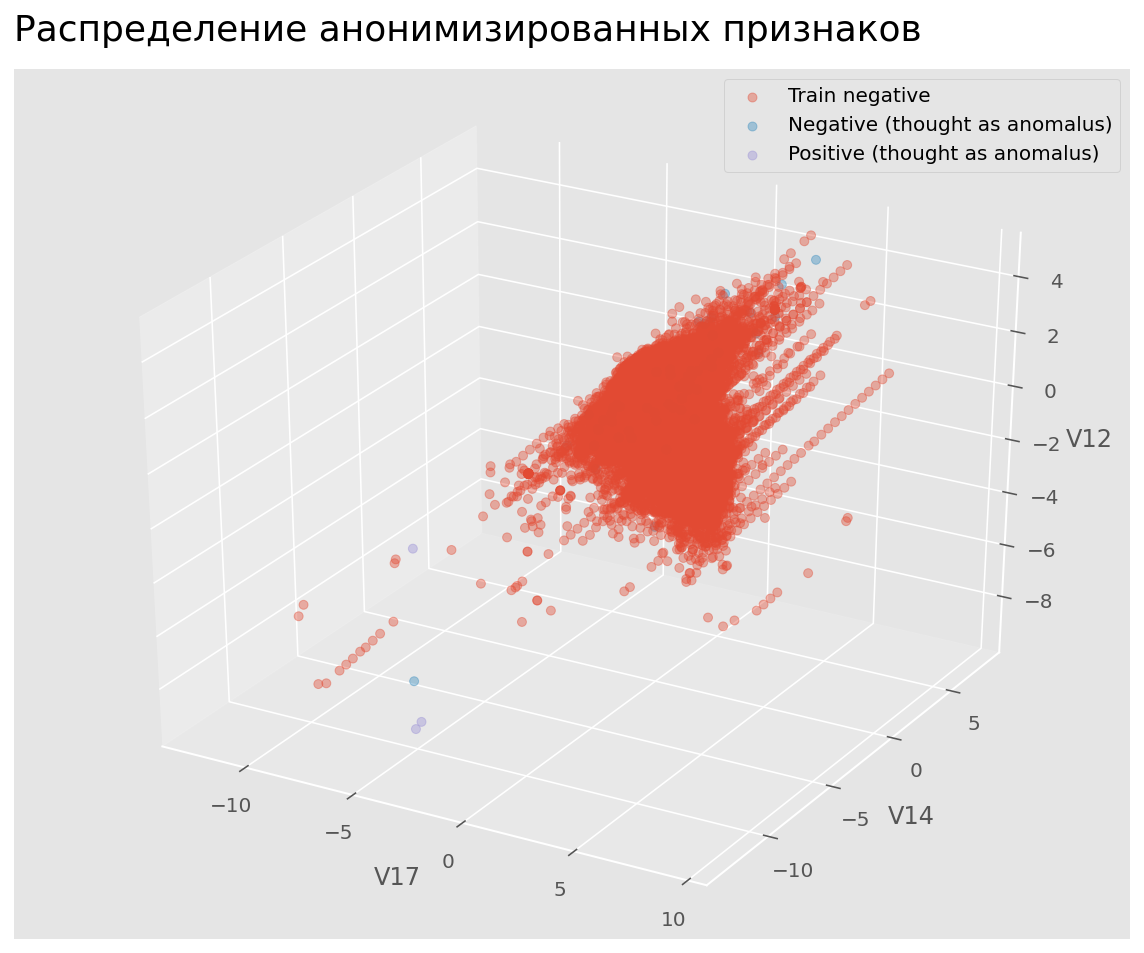

In [64]:
ax = plt.axes(projection='3d')

ax.scatter3D(negative_obj_with_low_score['V17'], negative_obj_with_low_score['V14'],
             negative_obj_with_low_score['V12'],
             label='Train negative', alpha=0.4)

ax.scatter3D(negative_obj_with_high_score['V17'], negative_obj_with_high_score['V14'],
             negative_obj_with_high_score['V12'], 
             label='Negative (thought as anomalus)', alpha=0.4)

ax.scatter3D(positive_obj_with_high_score['V17'], positive_obj_with_high_score['V14'],
             positive_obj_with_high_score['V12'], 
             label='Positive (thought as anomalus)', alpha=0.4)

ax.set_xlabel('V17')
ax.set_ylabel('V14')
ax.set_zlabel('V12')

ax.set_title('Распределение анонимизированных признаков', pad=14, fontsize=18, loc='left')

ax.legend();

Некоторые негативные объекты в тестовой выборке были достаточно далеко от основного кластера, поэтому они попали в глубокий лист и, соответственно, получили высокую оценку аномальности относительно других объектов.

#### Isolation Forest

In [42]:
from sklearn.ensemble import IsolationForest

In [43]:
np.random.seed(77)

iso_forest = IsolationForest(n_jobs=-1, n_estimators=150, contamination=0.002)
iso_forest.fit(X_train_scaled)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.002,
                max_features=1.0, max_samples='auto', n_estimators=150,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [44]:
y_pred_train_if = iso_forest.predict(X_train_scaled)
y_pred_train_if[y_pred_train_if == 1] = 0
y_pred_train_if[y_pred_train_if == -1] = 1

y_pred_test_if = iso_forest.predict(X_test_scaled)
y_pred_test_if[y_pred_test_if == 1] = 0
y_pred_test_if[y_pred_test_if == -1] = 1

In [45]:
get_metrics("Train", y_train, y_pred_train_if)

Train average precision = 0.089
Train k = 0.295
Train MCC = 0.295


In [46]:
get_metrics("Test", y_test, y_pred_test_if)

Test average precision = 0.000772
Test k = -0.000822
Test MCC = -0.000824


__Вывод__: да, в нашем случае EIF получился лучше IF.

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

#### Local Outlier Factor

In [47]:
from sklearn.neighbors import LocalOutlierFactor

In [48]:
np.random.seed(77)

lof_clf = LocalOutlierFactor(novelty=True, n_jobs=-1)
lof_clf.fit(X_train_scaled)
y_pred_train_lof = lof_clf.predict(X_train_scaled)
y_pred_test_lof = lof_clf.predict(X_test_scaled)

In [49]:
get_metrics("Train", y_train, y_pred_train_lof)

Train average precision = 0.0017
Train k = -0.000146
Train MCC = -0.00819


In [50]:
get_metrics("Test", y_test, y_pred_test_lof)

Test average precision = 0.000827
Test k = 4.96e-05
Test MCC = 0.00184


 #### One-Class SVM

In [51]:
from sklearn.svm import OneClassSVM

In [52]:
np.random.seed(77)

one_class_svm = OneClassSVM(kernel='linear', max_iter=100)
one_class_svm.fit(X_train_scaled)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='linear',
            max_iter=100, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred_train_svm = one_class_svm.predict(X_train_scaled)
y_pred_test_svm = one_class_svm.predict(X_test_scaled)

In [54]:
get_metrics("Train", y_train, y_pred_train_svm)

Train average precision = 0.00186
Train k = 2.67e-05
Train MCC = 0.000643


In [67]:
get_metrics("Test", y_test, y_pred_test_svm)

Test average precision = 0.000772
Test k = -1.63e-07
Test MCC = -0.000202


__Вывод__: данные методы работают хуже, чем EIF и IF.

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [57]:
def get_metrics(y_true, y_pred, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    print(f'AUC-PR = {auc(recall, precision):.3}')
    print(f'k = {cohen_kappa_score(y_true, y_pred):.3}')
    print(f'MCC = {matthews_corrcoef(y_true, y_pred):.3}')

In [58]:
train_new_features = np.column_stack((y_pred_train_eif, y_pred_train_if, 
                                      y_pred_train_lof, y_pred_train_svm)).reshape(-1, 4)

test_new_features = np.column_stack((y_pred_test_eif, y_pred_test_if, 
                                     y_pred_test_lof, y_pred_test_svm)).reshape(-1, 4)

In [59]:
X_train_scaled_new = np.hstack((X_train_scaled, train_new_features))
X_test_scaled_new = np.hstack((X_test_scaled, test_new_features))

In [60]:
catboost_clf.fit(X_train_scaled_new, y_train);

In [61]:
y_pred = catboost_clf.predict(X_test_scaled_new)
y_pred_proba = catboost_clf.predict_proba(X_test_scaled_new)[:, 1]

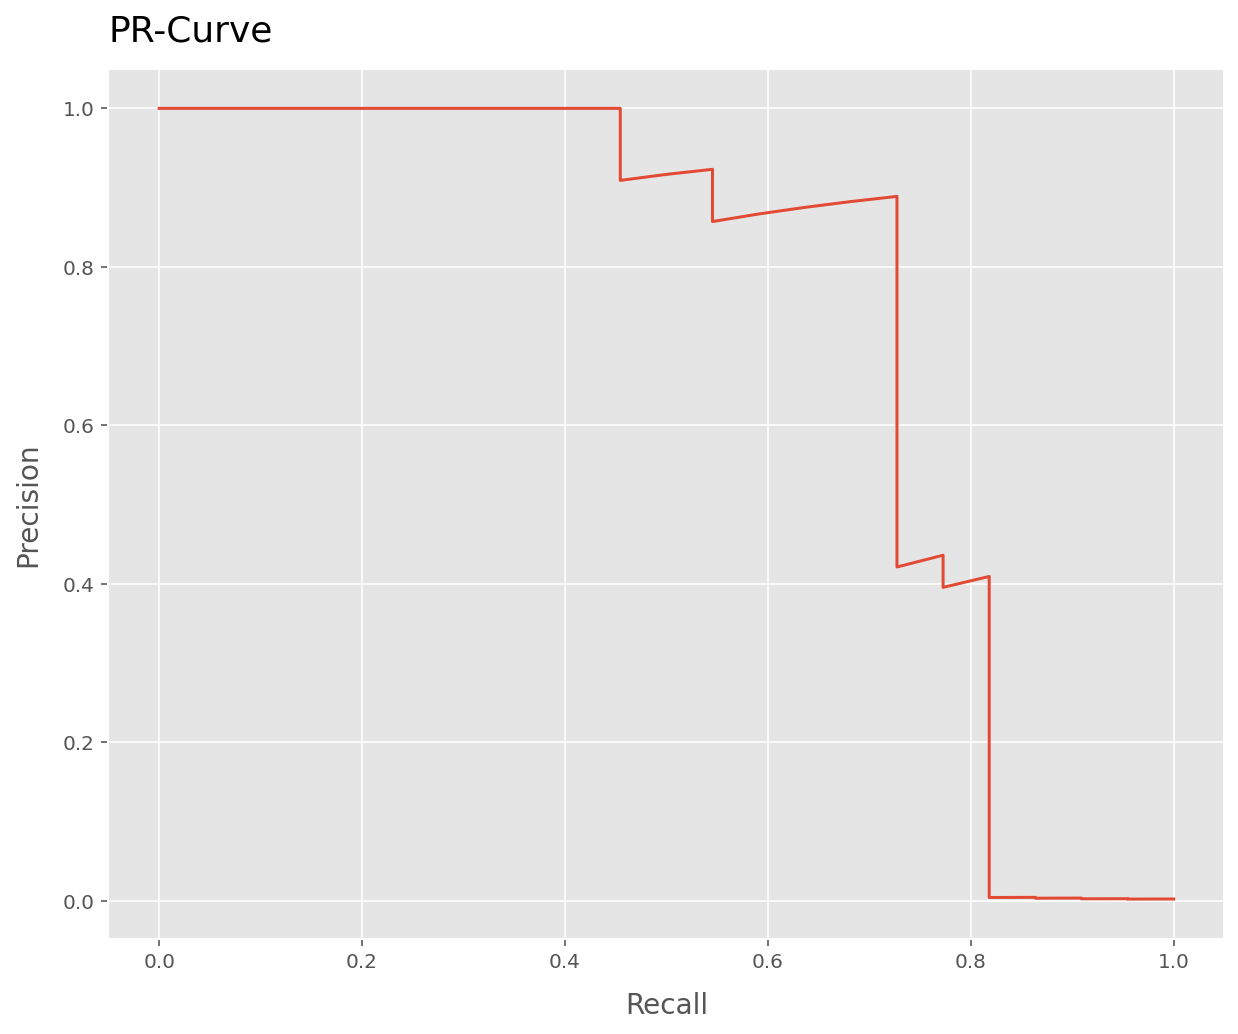

In [62]:
plot_pr_curve(y_test, y_pred_proba)

In [63]:
get_metrics(y_test, y_pred, y_pred_proba)

AUC-PR = 0.735
k = 0.8
MCC = 0.804


__Вывод__: действительно, качество получилось повысить за счет unsupervised-методов.

**Бонус. (0.5 балла).**

Ну что ж, вот и подошла к концу домашка по методам борьбы с несбалансированными данными. Надеемся, вы не сильно устали и вам еще не противно. А знаете, чье творчество тоже нельзя назвать сбалансированным? В течение своей жизни Роберт Фальк писал в самых разных жанрах, то ломая все традиции, то, наоборот, продвигая их в массы. В связи с этим мы рекомендуем ознакомиться с его работами на [выставке](https://www.tretyakovgallery.ru/exhibitions/robert-falk/) в Новой Третьяковке. Там вы сможете пронаблюдать весь творческий путь одного из знаковых советских живописцев.

Данный номер будет зачтен, если вы предоставите небольшой фотоотчет и расскажете, что вам удалось понять после посещения экспозиции.


Роберт Фальк, действительно, писал в самых разных жанрах: на экспозиции, переходя из зала в зал, видишь, как художник проходил через этапы неопритивизма, сезаннизма, кубизма и авангардизма, а в начале 1920-х годов обратился к старым мастерам.

В общем, разносторонний и талантиливый художник.

P.S. Фото в anytask.

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. Если вы получите ровно 0, то мы посчитаем вас невероятно везучим человеком и в качестве поощрения зачтем теорминимум на коллоквиуме. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `хочу`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [ ]:
import numpy as np

np.random.randn()

-0.9757077064289599